# PV Clustering

### June 7, 2020

This notebook is based on the conference paper available here: http://www.ibpsa.org/proceedings/BS2019/BS2019_210725.pdf

**Paper Abstract:** This paper demonstrates a clustering method for grouping PVs of arbitrary orientation affected by nonuniform local shading. For a project with 44,000 PV panels cladding doubly curved roof surfaces, every panel has a unique orientation. In addition, clerestory windows cause non-uniform near-field shading. The combination of curvature and shading causes every panel to receive a different amount of irradiance at any time. The PV panel with lowest output (lowest irradiance) in a MPPT string limits the output of the whole string. The method for grouping 44,000 PV panels into 296 MPPT strings affects the total annual energy producing. The PV array grouped with clustering generated 7.7% more energy annually compared to the same array grouped in a simple grid.

The clustering method from the paper (which used octave) has be re-coded using python and scikit-learn in this notebook.

Here we're exploring the methods (and a few additional methods) with roof bay 5 as an example. Roof bay 5 contains 1175 PV panels, has a shadow causing clearstory at the upper left edge.
<img src="Figure5.png" width=500px>

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time

### PV panel coordinates
The first file to load is the position and normal vector for all the PV panels. These positions represent the location of the panels in real world space with +Y as north, +X as east, and +Z as up.

In [2]:
PV_geometry = pd.read_csv('bay_05_wnormals.txt',
                          index_col=False,
                          sep='\t',
                          names=['x','y','z','xdir','ydir','zdir'])
PV_geometry.head()

x        y         z      xdir      ydir      zdir
0 -63.4939 -218.917  57.39409  0.340272  0.126066  0.931838
1 -61.3550 -217.368  56.53611  0.311589  0.121175  0.942459
2 -61.3002 -220.484  56.73805  0.321068  0.116131  0.939909
3 -59.1910 -215.821  55.75290  0.283460  0.114895  0.952077
4 -59.1422 -218.938  55.93800  0.293467  0.111522  0.949442

### Irradiance on selected sunny days
The next file to load conatins irradiance on the panels at hourly increments on sunny days. The days are chosen from a TMY weather file, and the panel irradiance was simulated using the diffuse and dirrect irradiance, and position of the sun from the increments in the weather file. There are 73 hours from seven days. These are the values used to cluster the PV panels.

The days selected are: 1/21, 2/25, 3/24, 4/21, 5/21, 6/27, and 12/23

The datafram has 73 columns (one for each daylight hour on the 7 days) and 1175 rows (one for each PV panel on bay 5

In [3]:
sunny_days= pd.read_csv('sky/sunnydays.wea',
                           index_col=False,
                           skiprows=6,
                           header=None,
                           sep=' ',
                           names=['month','day','hour','DNI','DHI'])
sunny_days['h'] = np.floor(sunny_days['hour'])
sunny_days['m'] = 60 * ( sunny_days['hour'] - sunny_days['h'] )
sunny_days['timestamp'] = sunny_days.apply( 
    lambda x : f"{x['month']:0.0f}/{x['day']:0.0f} {x['h']:0.0f}:{x['m']:0.0f}",
    axis=1)

In [4]:
PV_irrad_sunny_days = pd.read_csv('bay_05_irrad_sunnydays.txt',
                           index_col=False,
                           skiprows=7,
                           header=None,
                           sep='\t',
                           names=sunny_days['timestamp'].tolist())
PV_irrad_sunny_days.head(10)

1/21 9:30  1/21 10:30  1/21 11:30  1/21 12:30  1/21 13:30  1/21 14:30  \
0  185.61412   235.31117   262.07126   233.78324   191.07989  112.836170   
1  191.09562   247.65979   275.94636   252.08739   219.80486  121.193680   
2  197.79418   251.03109   279.63151   253.76834   210.55725  132.885560   
3  197.02886   261.64145   290.60440   277.29829   239.44388  101.896760   
4  202.61895   260.94418   294.61436   276.83813   237.35804  153.860160   
5  203.50100   264.56974   296.59723   273.56021   232.89315  150.909690   
6  201.49283   272.36561   311.75741   296.76131   263.52980   78.859785   
7  203.86451   270.96599   312.32526   296.81755   257.52038  173.769390   
8  211.50909   274.19865   310.27010   295.45725   253.52074  169.721400   
9  214.08655   274.60066   310.38494   291.03226   251.09469  163.564260   

   1/21 15:30  2/25 10:30  2/25 11:30  2/25 12:30  ...  12/23 7:30  \
0   69.058983   323.63188   412.06757   421.53892  ...    3.775695   
1   67.294195   329.30928   425.12970   441.34019  ...    3.466167   
2   72.842641   333.35112   429.02639   446.89413  ...    3.938332   
3   65.932735   334.31540   444.92044   467.20822  ...    3.264447   
4   72.034608   339.69334   447.40253   466.52906  ...    3.646420   
5   75.273669   344.18574   445.74786   461.85050  ...    4.026886   
6   64.931857   339.22711   462.23101   489.32475  ...    3.214098   
7   71.265191   345.02636   462.58618   490.69643  ...    3.634854   
8   75.124070   347.71737   461.39589   481.40367  ...    3.889603   
9   77.169332   350.97300   459.79475   482.87665  ...    4.356566   

   12/23 8:30  12/23 9:30  12/23 10:30  12/23 11:30  12/23 12:30  12/23 13:30  \
0   59.690720   146.38878    197.87658    206.07658    182.63616    117.47185   
1   62.261400   153.02842    209.97038    225.93592    203.16741    140.14372   
2   65.748916   160.45128    211.26372    224.23827    201.52109    138.56252   
3   64.175068   159.95295    222.35724    244.61407    226.58028    164.71197   
4   67.890184   160.79493    223.08992    243.18146    221.64777    158.97512   
5   72.106773   162.72917    225.74323    243.43855    220.55366    155.89902   
6   68.854785   166.18050    235.22089    266.83901    244.25738    185.47914   
7   70.641518   168.90402    235.88945    261.56663    241.91199    185.36095   
8   72.582742   173.53109    237.79787    260.29500    241.97948    176.53884   
9   74.080884   177.20839    238.09538    260.03130    239.90005    175.07315   

   12/23 14:30  12/23 15:30  12/23 16:30  
0    60.927287    57.546636     7.887995  
1    57.950641    56.102115     7.600906  
2    70.857611    60.475359     8.180507  
3    54.890396    54.991630     7.371226  
4    76.833604    59.745061     7.961158  
5    82.961825    62.351282     8.358731  
6    54.802046    54.169257     7.186704  
7    87.850463    59.074248     7.767214  
8    99.983868    62.115989     8.192403  
9   102.831410    63.797733     8.482003  

[10 rows x 73 columns]

### Annual Hourly Irradiance
The final file to load contains Irradiance on each PV panel for all hours in the TMY weather file. The dataframe has 8760 columns (one for each hour of the year) and 1175 rows (one for each PV panel).

In [5]:
all_days= pd.read_csv('sky/Moffett.wea',
                      index_col=False,
                      skiprows=6,
                      header=None,
                      sep=' ',
                      names=['month','day','hour','DNI','DHI'])
all_days['h'] = np.floor(all_days['hour'])
all_days['m'] = 60 * ( all_days['hour'] - all_days['h'] )
all_days['timestamp'] = all_days.apply( 
    lambda x : f"{x['month']:0.0f}/{x['day']:0.0f} {x['h']:0.0f}:{x['m']:0.0f}",
    axis=1)

In [6]:
PV_irrad_all_days = pd.read_csv('bay_05_irrad_alldays.txt',
                                index_col=False,
                                skiprows=7,
                                header=None,
                                sep='\t',
                                names=all_days['timestamp'].tolist())

PV_irrad_all_days.head()

1/1 0:30  1/1 1:30  1/1 2:30  1/1 3:30  1/1 4:30  1/1 5:30  1/1 6:30  \
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   1/1 7:30   1/1 8:30   1/1 9:30  ...  12/31 14:30  12/31 15:30  12/31 16:30  \
0  2.450213  59.822393  161.14958  ...    96.907864    38.279221     6.188614   
1  2.258428  62.526320  165.30597  ...    95.591616    37.701426     6.095520   
2  2.554192  65.736090  173.08235  ...    99.839848    39.342195     6.350118   
3  2.139230  64.059414  171.12973  ...    94.543385    37.232654     6.019378   
4  2.379202  67.458865  174.49689  ...    99.277545    39.045406     6.300263   

   12/31 17:30  12/31 18:30  12/31 19:30  12/31 20:30  12/31 21:30  \
0          0.0          0.0          0.0          0.0          0.0   
1          0.0          0.0          0.0          0.0          0.0   
2          0.0          0.0          0.0          0.0          0.0   
3          0.0          0.0          0.0          0.0          0.0   
4          0.0          0.0          0.0          0.0          0.0   

   12/31 22:30  12/31 23:30  
0          0.0          0.0  
1          0.0          0.0  
2          0.0          0.0  
3          0.0          0.0  
4          0.0          0.0  

[5 rows x 8760 columns]

### Data Exploration with Plotting

In [7]:
## this is a helper function to plot PV panels
def PV_scatter(position_x, position_y, color, cmap='rainbow', vmin=0, vmax=1000, size=3, title=''):
    fig = plt.figure(figsize=(6,6))
    plt.scatter(position_x, position_y, c=color,
                s=size, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.gca().set_title(title)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().xaxis.set_visible(False)
    plt.gca().yaxis.set_visible(False)
    

<IPython.core.display.Javascript object>


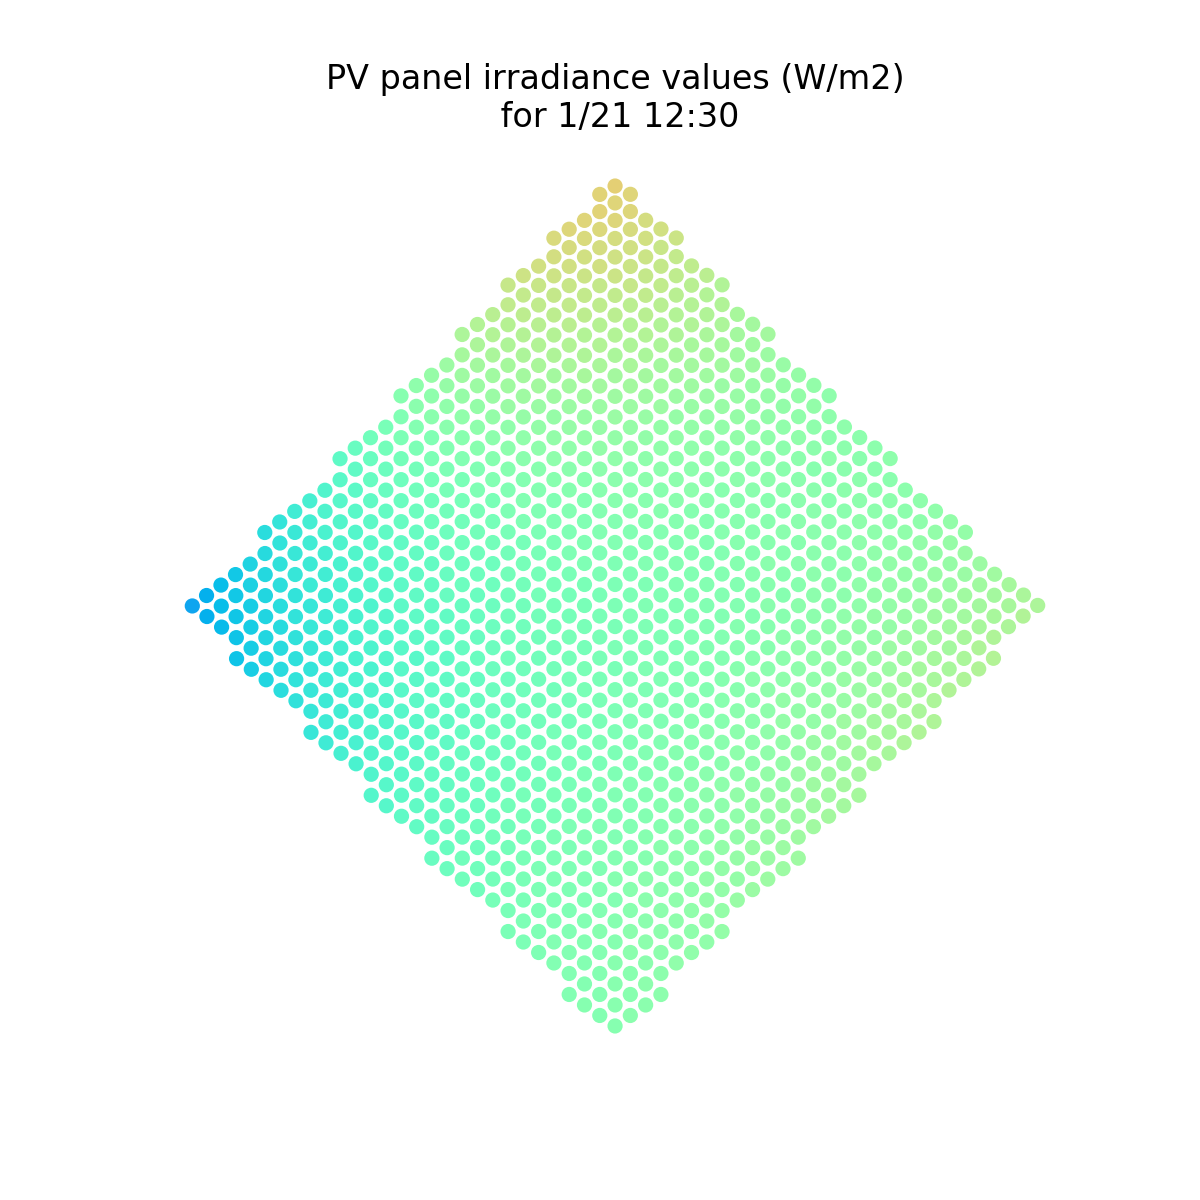

In [8]:
irrad_max = PV_irrad_sunny_days.max().max()
column_to_plot = 3

PV_scatter(PV_geometry['x'], PV_geometry['y'],
           color=PV_irrad_sunny_days.iloc[:,column_to_plot],
           size=20,
           vmax=irrad_max,
           title='PV panel irradiance values (W/m2)\n for ' + PV_irrad_sunny_days.columns[column_to_plot])

Plotting hourly irradiance maps for a sunny day in May.

<IPython.core.display.Javascript object>


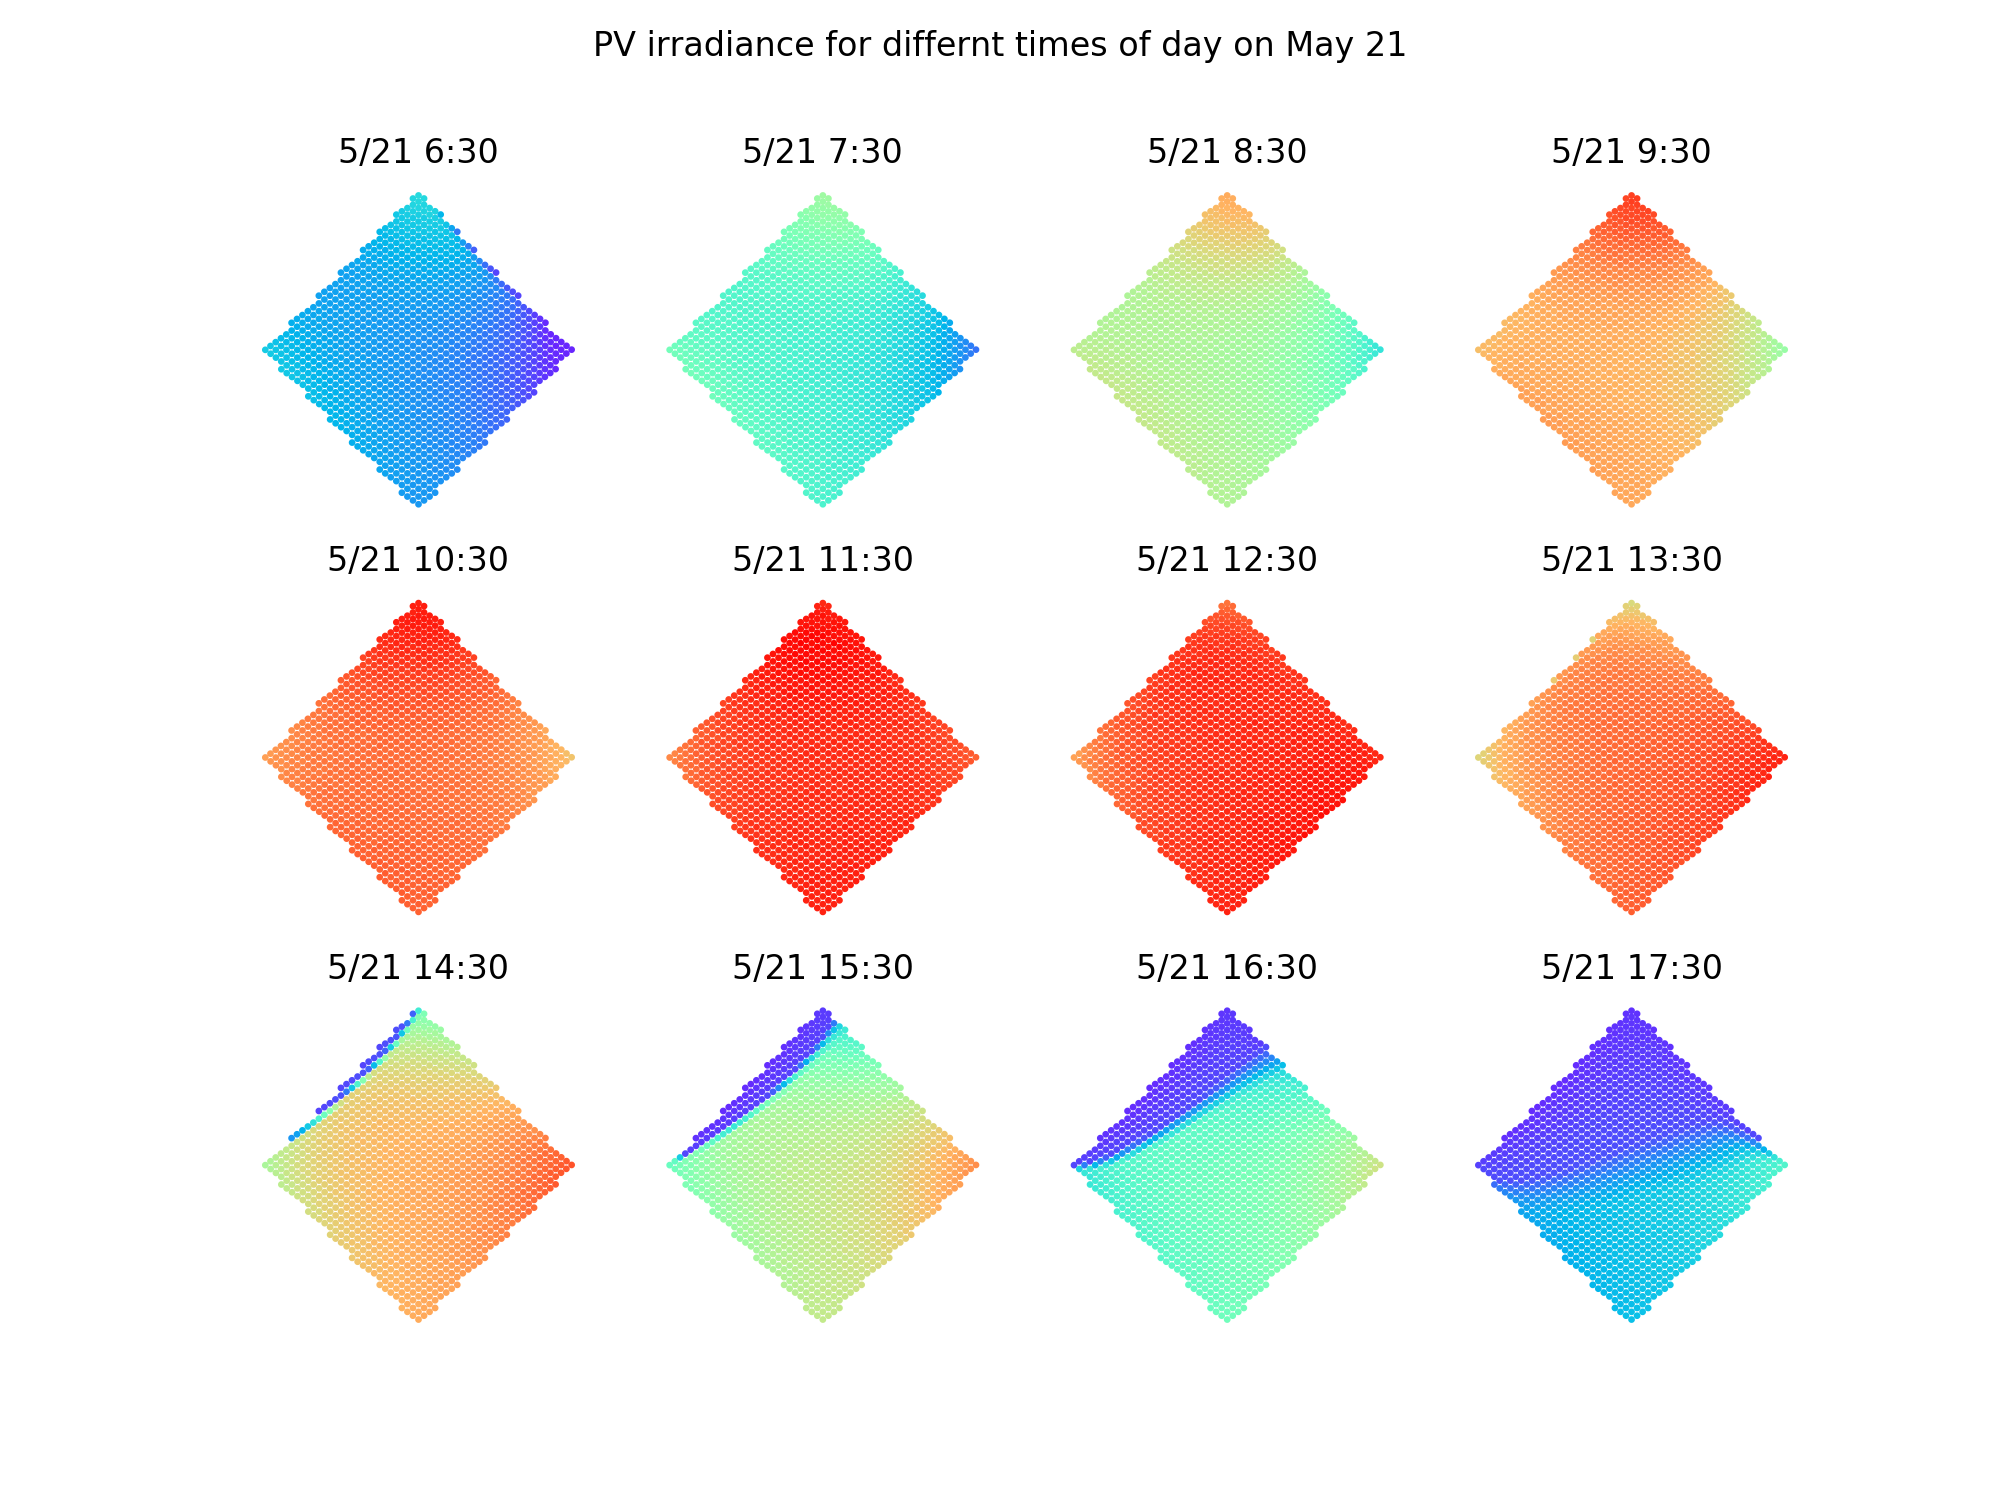

In [9]:
irrad_max = PV_irrad_sunny_days.max().max()
irrad_plot, axs = plt.subplots(3,4,figsize=(10,7.5))
irrad_plot.suptitle('PV irradiance for differnt times of day on May 21')
first_chart = 38
for i,ax in enumerate(axs.ravel()):
    ax.scatter(PV_geometry['x'], PV_geometry['y'], c=PV_irrad_sunny_days.iloc[:,i+first_chart],
                s=2, cmap='rainbow', vmin=0, vmax=irrad_max)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_title(PV_irrad_sunny_days.columns[i+first_chart])
irrad_plot.figsize=(16,12)

### Principal Component Analysis
Reducing from 73 irradiance dimensions to 2 dimensions for plotting.

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca_irrad_sunny_days = pca.fit_transform(PV_irrad_all_days)

print("explained variance ratio: ",pca.explained_variance_ratio_)


explained variance ratio:  [0.68805444 0.15149994 0.06084838]


The explained variance ratio describes how much of the total variance in the data is captured by each dimension in the PCA. In this example, the first dimension (X axis) recreates 68.8% of the total variance in the 73-dimensional data. The second dimension (y-axis) recreates 15.1% of variance in the 73-dimensional data. So with this PCA transform we can illustrate 84% of the variance in the original data with 2 dimensions.

And now to plot the PV panels in the PCA transform.

<IPython.core.display.Javascript object>


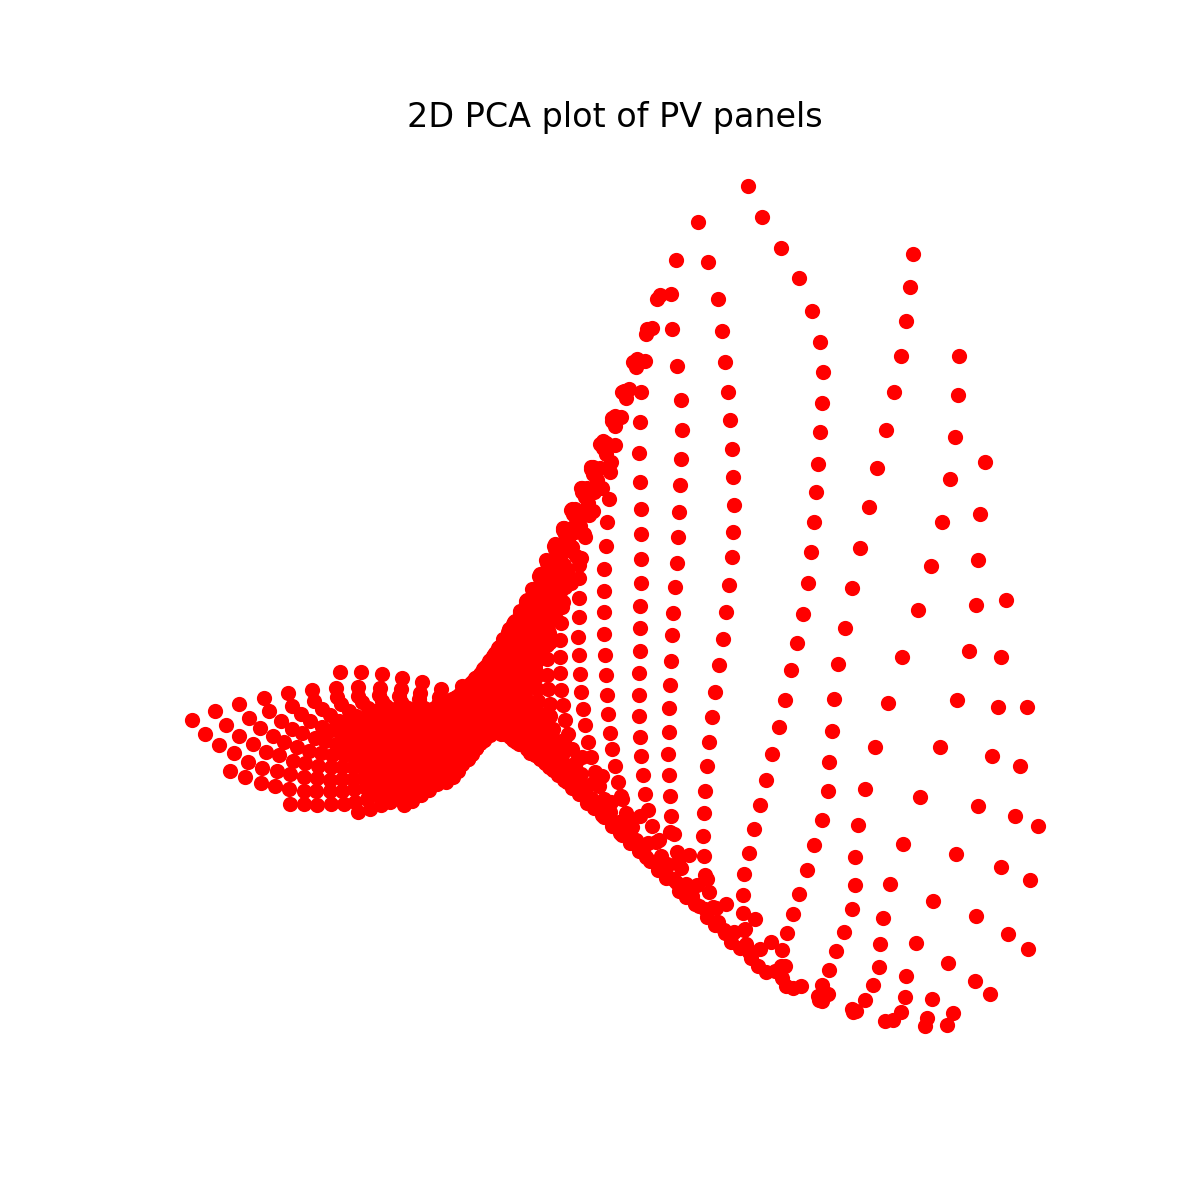

In [11]:
PV_scatter(pca_irrad_sunny_days[:,0], pca_irrad_sunny_days[:,1],
           color=[(1,0,0)], size=20, title='2D PCA plot of PV panels')

<IPython.core.display.Javascript object>


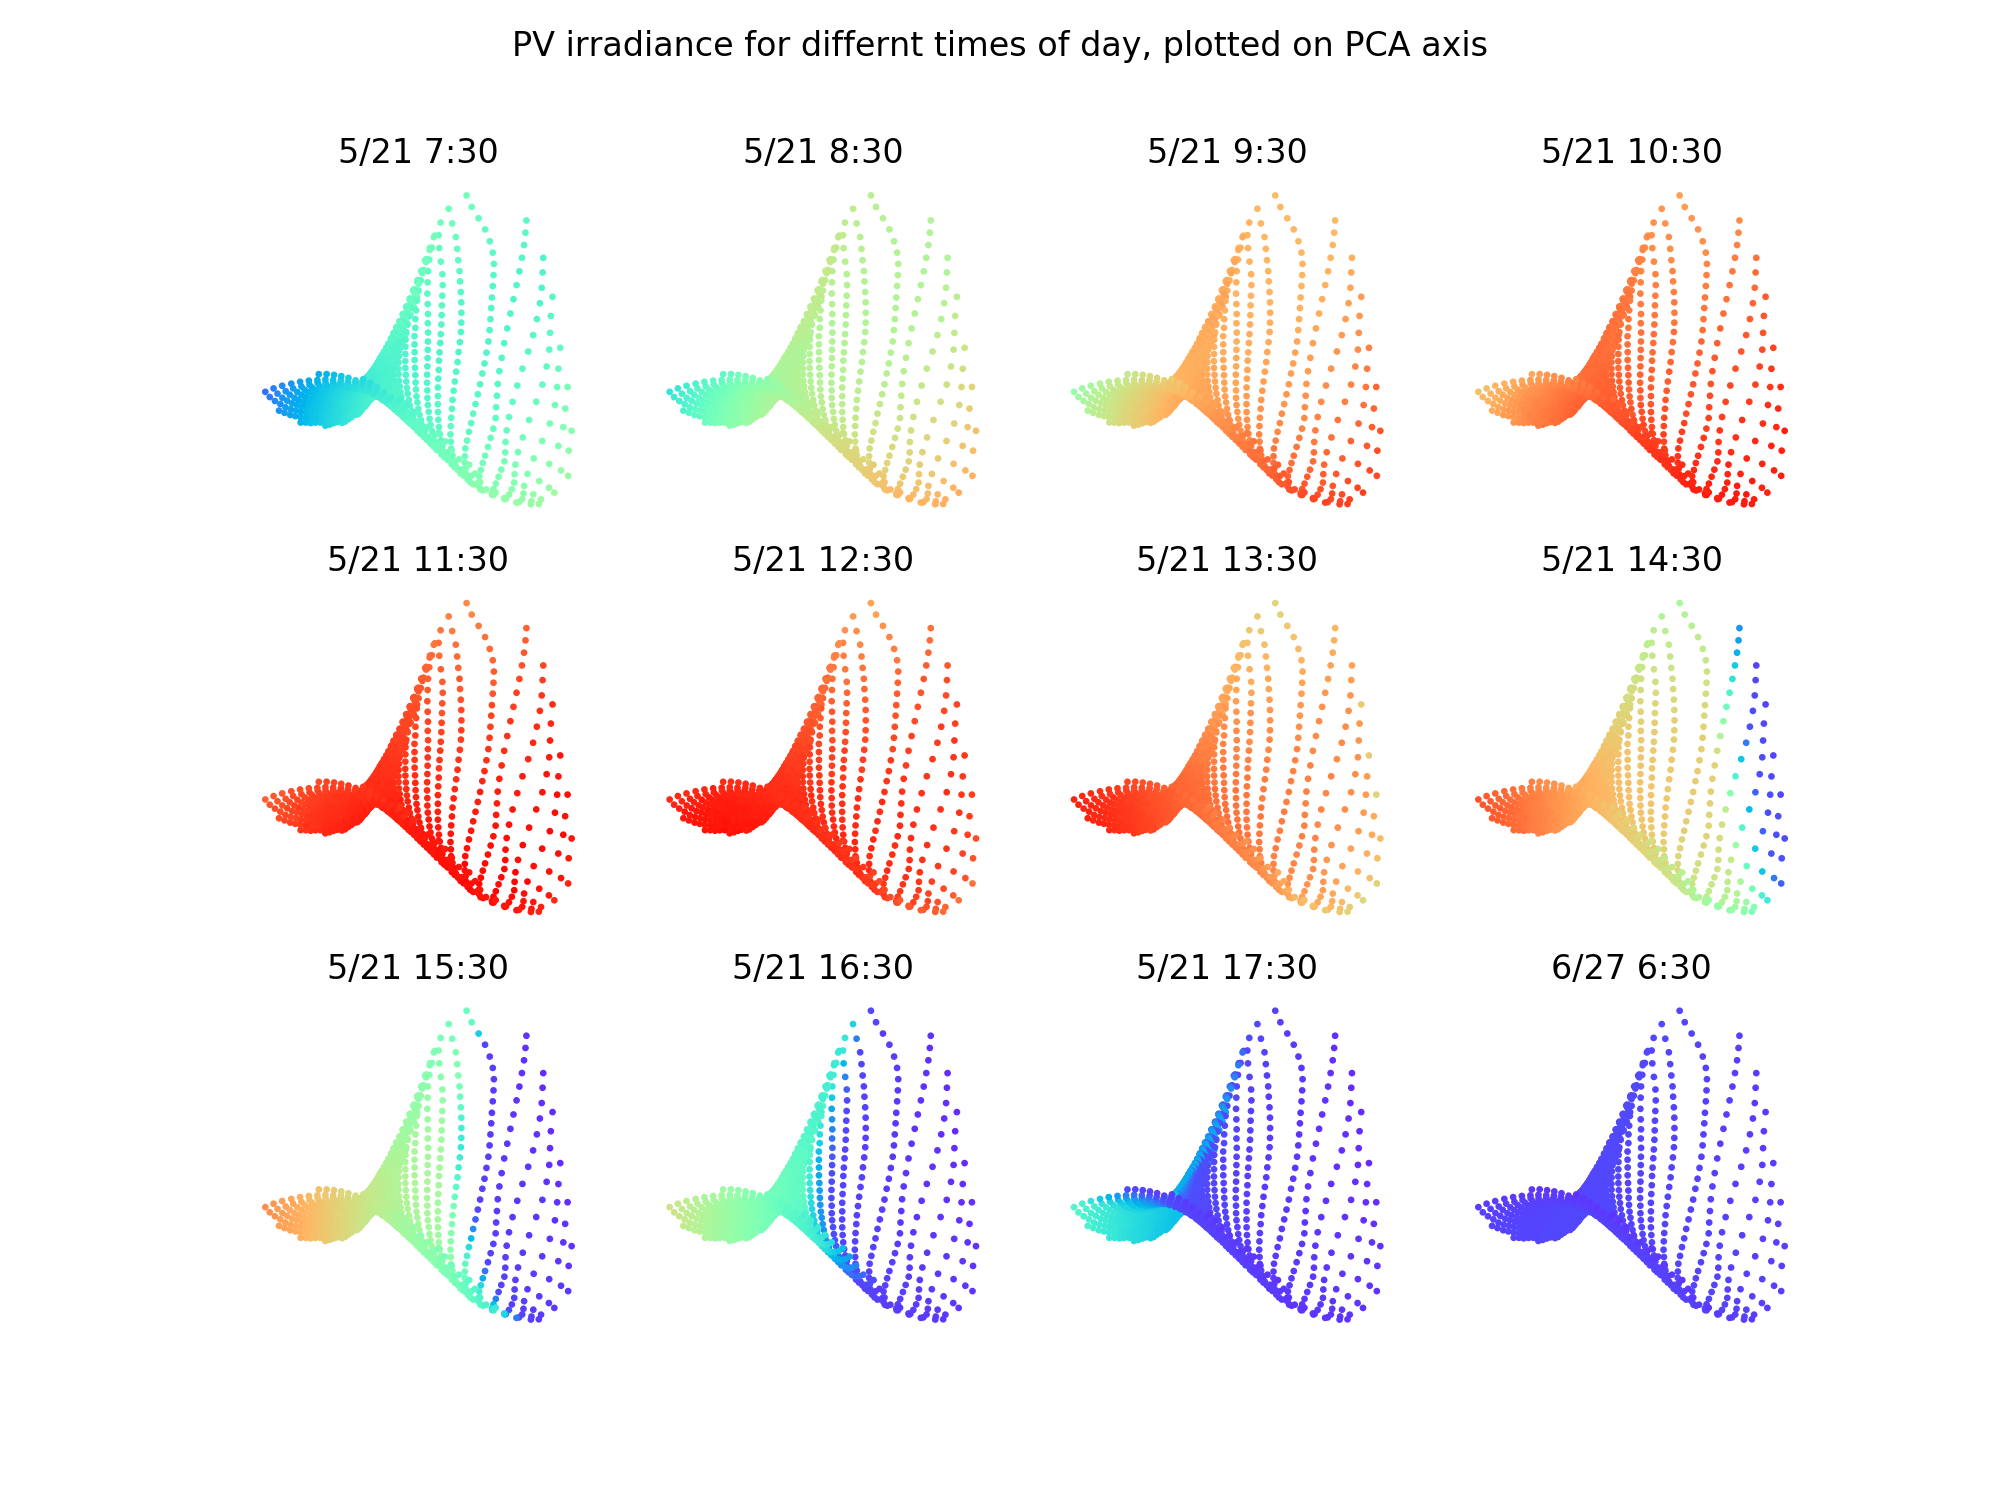

In [369]:
irrad_max = PV_irrad_sunny_days.max().max()
irrad_plot, axs = plt.subplots(3,4,figsize=(10,7.5))
irrad_plot.suptitle('PV irradiance for differnt times of day, plotted on PCA axis')
first_chart = 39
for i,ax in enumerate(axs.ravel()):
    ax.scatter(pca_irrad_sunny_days[:,0], pca_irrad_sunny_days[:,1], c=PV_irrad_sunny_days.iloc[:,i+first_chart],
                s=2, cmap='rainbow', vmin=0, vmax=irrad_max)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_title(PV_irrad_sunny_days.columns[i+first_chart])
irrad_plot.figsize=(16,12)

Plotting side-by-side irradiance maps in physical location and PCA coordinates.

In [12]:
## this is a helper function to plot irradiance on real world location alongside PCA coordinates
def PV_double_scatter(dot_color, cmap='rainbow', vmin=0, vmax=1000, size=12, title=''):
    fig, axs = plt.subplots(1,2,figsize=(10,5))
    for i,ax in enumerate(axs.ravel()):
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    
    axs[0].scatter(PV_geometry['x'], PV_geometry['y'], c=dot_color,
                s=size, cmap=cmap, vmin=vmin, vmax=vmax)
    axs[0].set_title('physical location')
    
    axs[1].scatter(pca_irrad_sunny_days[:,0], pca_irrad_sunny_days[:,1], c=dot_color,
                s=size, cmap=cmap, vmin=vmin, vmax=vmax)
    axs[1].set_title('PCA coordinates')    
    
    fig.suptitle(title)


<IPython.core.display.Javascript object>


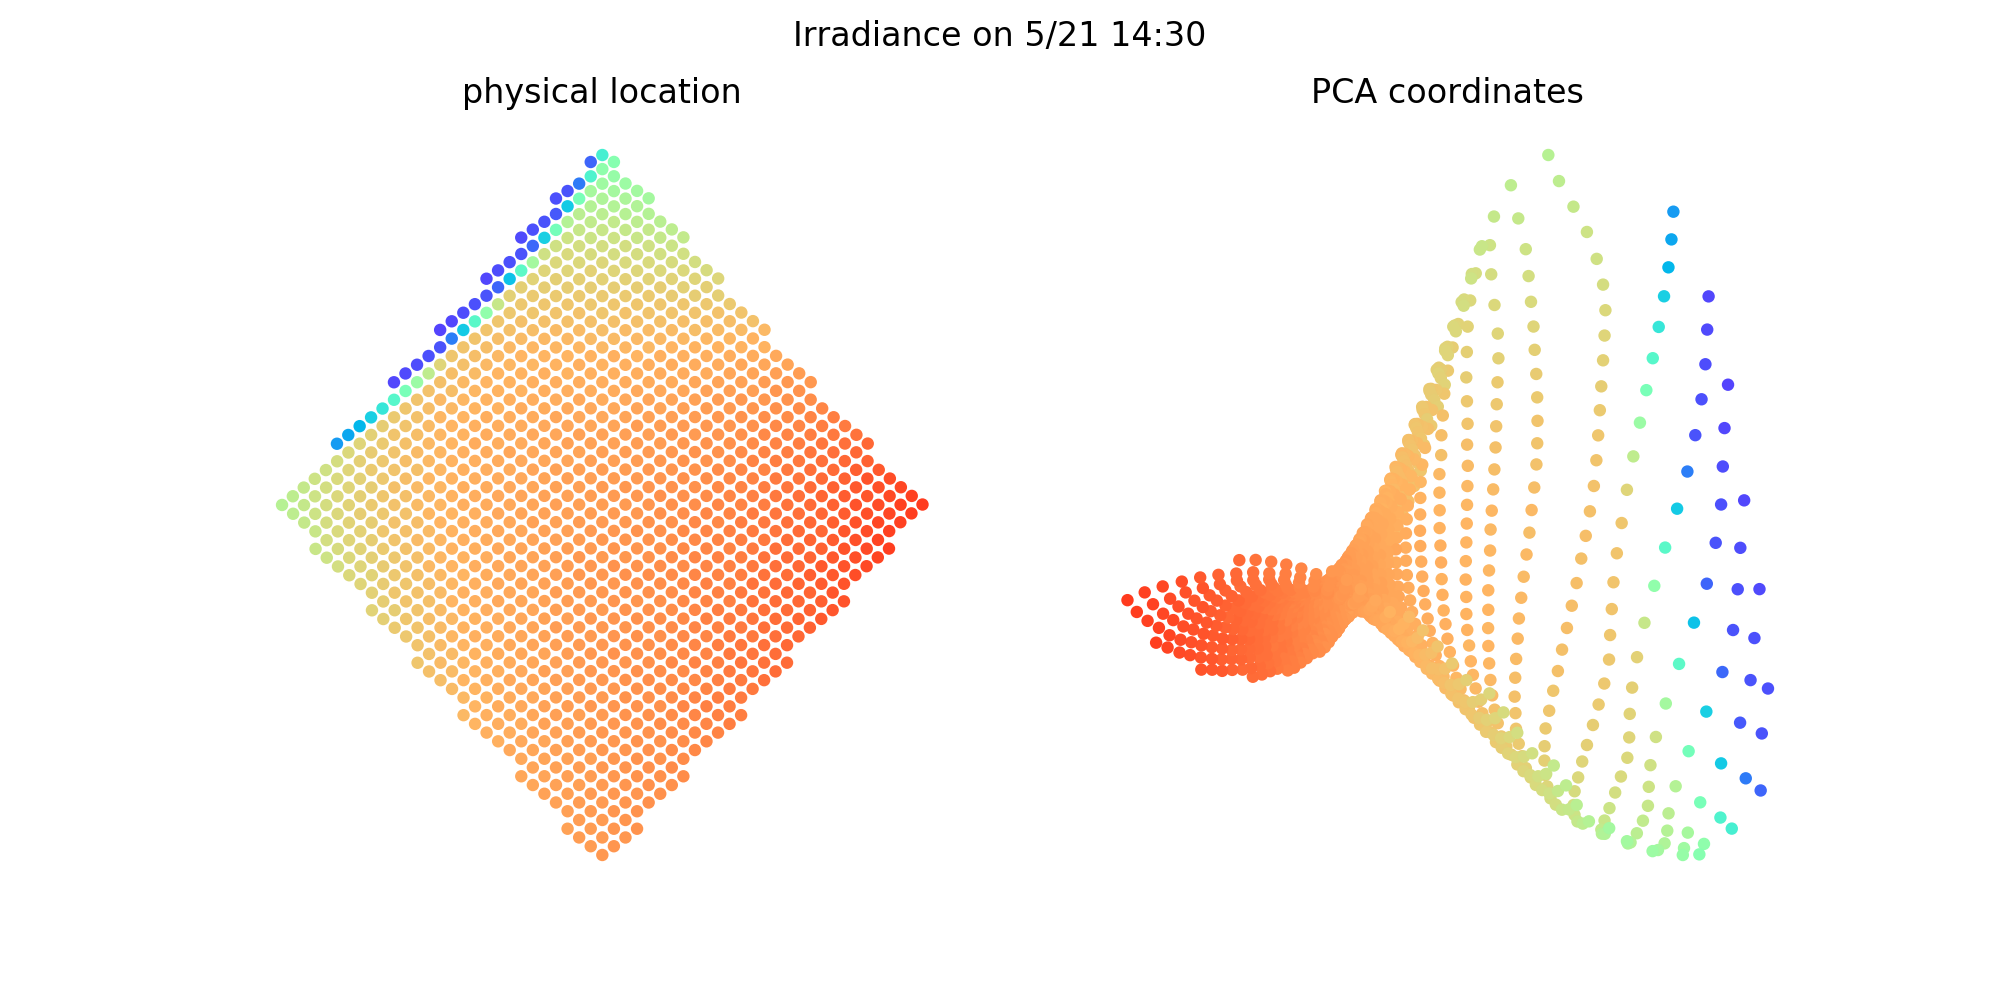

In [13]:
column_to_plot=46
PV_double_scatter(PV_irrad_sunny_days.iloc[:,column_to_plot],
               title='Irradiance on ' + PV_irrad_sunny_days.columns[column_to_plot] )

# Kmeans Clustering

In [14]:
from sklearn.cluster import KMeans

Each roofbay has 8 MPPTs which can accomodate between 35 and 220 PV panels. We want our clustering algorithm to create eight clusters.

In [15]:
n_clust = 8

We feed the clustering algorithm the dataframe containing panel irradiance for 73 daylight hours on seven sunny days. The KMeans algorithm creates groups that minimize eucledian distance between each panel's irradiance vector and the centroid for the group. The result is eight groups of panels where each panels irradiance is closer to the center of the group to which it belongs than any other group. The grouped PV panels therefore have simmilar irradiance profiles to each other.

In [16]:
%%time
clust_km = KMeans(n_clusters=n_clust)
clust_km.fit(PV_irrad_sunny_days)

CPU times: user 647 ms, sys: 118 ms, total: 766 ms
Wall time: 132 ms


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

<IPython.core.display.Javascript object>


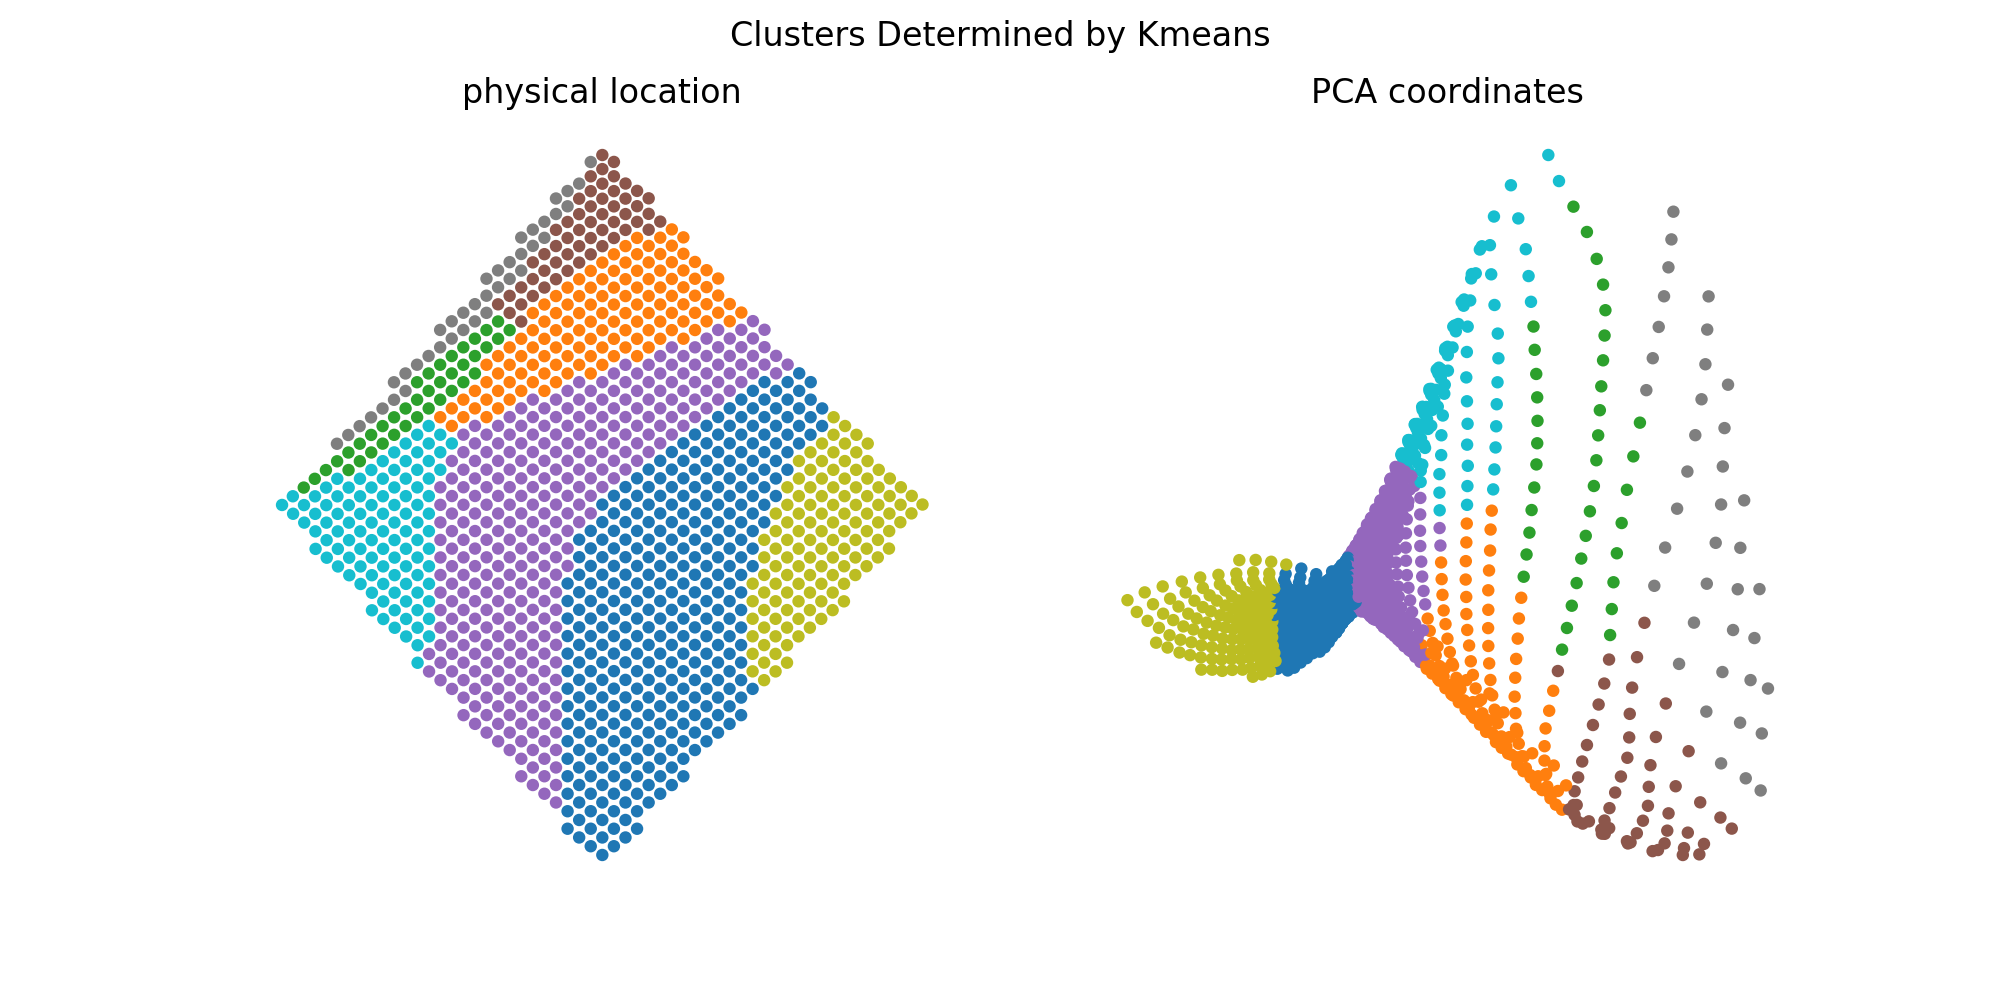

In [17]:
PV_double_scatter(clust_km.labels_, cmap='tab10', vmax=7,
           title='Clusters Determined by Kmeans'
          )

The KMeans algortihm created groups in less than a second. However, there is no way to constrain the sizes of the groups with KMeans (or any other common clustering algorithm) and several of the created groups violate the size constraints of the MPPTs. For example, the group along the upper left edge has less than 35 panels, and the two groups in the center have more than 220 panels.

# Iterative Reassignment

An iterative reassignment process was used to move PVs to other groups. The process is as follows:
1. Reassign panels as follows:
    a. In groups that exceed MPPT maximum, move the furthest PVs from the centroid (in 73-dimensional irracdiance space) to the next closest group.
    b. In groups that have too few panels, grab the next closest PVs from other groups.
2. Recalculate centroids of all clusters
3. Recalculate distance from all PV panels to all cluster centroids
4. Reassign all panels to the group with the closes centroid. 

The last step moves back towards the original KMeans result, but we would like a solution where panels are in a prefered group, however we don't continue to calculate new centroid and reasign repeatedly, because that eventually returns us to the Kmeans result.

We also use an iteratively incremented value that causes the process to reassign one more panel in each iteration. This step acts to prevent the process from getting stuck at an equilibrium that repeats the same result without meeting the constraints.

### Cluster size constraints

In [18]:
cluster_minimum = 35
cluster_maximum = 220

### Helper Functions
The following functions are used to perform the steps in the iterative reassignment process.

In [19]:
def meets_size_constraints(cluster_sizes, min_size, max_size):
    '''checks each cluster to ensure it meets minimum and maximum size constraints.
       Returns True if all clusters meet constraints, otherwise False'''
    meets_constraints = [ a[0] >= min_size and a[0] <= max_size for a in cluster_sizes ]
    return(all(meets_constraints))

def calc_cluster_distances(datapoints, centers):
    '''calculates euclidean distance from data points to all cluster centers.
       returns numpy array of distances.
       datapoins is an MxD array
       centers in an NxD array
       returns an MxN array of distances from points (M) to centers (N)
       vectorized implementation borrowed from: 
       https://medium.com/@souravdey/l2-distance-matrix-vectorization-trick-26aa3247ac6c'''
    squared_distances = (-2 * np.dot(datapoints, centers.T)
                         + np.sum(centers**2, axis=1) 
                         + np.sum(datapoints**2, axis=1)[:, np.newaxis])
    distances = squared_distances ** 0.5
    return(distances)

def gather_more(distances, cluster_index, new_total):
    '''sets the distance of new_total closest points to centroid to zero so that the points are asigned
       to that centroid, increasing the number of points in a cluster to new_total'''
    ordered = sorted(distances[:,cluster_index])
    cutoff = ordered[new_total]
    distances[ distances[:,cluster_index] < cutoff, cluster_index ] = 0
    return(distances)
    
def shed_some(distances, cluster_index, new_total):
    '''sets the distance of points further than the new_total number of closest points to a infinity
       so that these points are asinged to a different cluster, liminting the number of points in the
       selected cluster to new_total'''
    ordered = sorted(distances[:,cluster_index])
    cutoff = ordered[new_total]
    distances[ distances[:,cluster_index] >= cutoff, cluster_index ] = np.inf
    return(distances)
    
def assign_to_closest(distances):
    '''takes the index of the shortest distance for each data point and assigns the data point to that cluster'''
    cluster_id = np.array([ d.argmin() for d in distances ])
    return(cluster_id)
    
def calc_cluster_centers(datapoints, num_clusters, cluster_id):
    '''calculates new cluster centroids by averaging datapoint coordinates assigned to a cluster '''
    centroids = [[ np.mean(d) for d in datapoints[ cluster_id == cls_id].T ] for cls_id in range(num_clusters) ] 
    return(np.array(centroids))

def calc_inertia(distances, cluster_id):
    '''calculates the inertia (summed squared distance of datapoints to its assigned cluster)'''
    square_distances = [ dist[cls_id]**2 for dist, cls_id in zip(distances, cluster_id)]
    inertia = np.sum(square_distances)
    return(inertia)

def calc_cluster_sizes(cluster_ids, num_clusters):
    cluster_sizes = np.array([ [sum( cluster_ids == i ),i] for i in range(num_clusters)])
    return(cluster_sizes)


In [25]:
#assign the dataframe to a numpy array to use vectorization
clustering_datapoints = PV_irrad_sunny_days.to_numpy()

#initalize the clusters with the kmeans result
cluster_ids = clust_km.labels_
cluster_centroids = clust_km.cluster_centers_

#calculate a distance matrix
cluster_distances = calc_cluster_distances(clustering_datapoints, cluster_centroids)

#calculate the initial cluster sizes
cluster_sizes = calc_cluster_sizes(cluster_ids, n_clust)

#calculate the initial inertia
inertia = calc_inertia(cluster_distances, cluster_ids)

#print sizes and initial inertia
print(cluster_sizes[:,0], inertia)

[356 131  39 323  55  39 126 106] 92825021.64898461


In [26]:
%%time
#This cell performs the iterative reassignment.
#itr keeps track of how many iterations we've done.
itr=0

#while constrains are not met (and iterator is less than the maximum size)
while not meets_size_constraints(cluster_sizes, cluster_minimum, cluster_maximum) and itr < cluster_maximum:

    for clust in cluster_sizes:
        if clust[0] > cluster_maximum:
            #if cluster exceeds max size, reduce size of cluster to (maximum - itr)
            cluster_distances = shed_some(cluster_distances, clust[1], cluster_maximum-itr)
            
        elif clust[0] < cluster_minimum:
            #if cluster is less than min size, increase size of cluster to (minimum + itr)
            cluster_distances = gather_more(cluster_distances, clust[1], cluster_minimum+itr)
        
        #modifying max and min size with itr allows us to slowly increase the severity of the cluster
        #reassignment avoiding getting stuck in equilibrium.
    
    cluster_ids = assign_to_closest(cluster_distances)
    cluster_centroids = calc_cluster_centers(clustering_datapoints, n_clust, cluster_ids)
    cluster_distances = calc_cluster_distances(clustering_datapoints, cluster_centroids)
    pre_inertia = calc_inertia(cluster_distances, cluster_ids)
    cluster_ids = assign_to_closest(cluster_distances)
    
    cluster_sizes = calc_cluster_sizes(cluster_ids, n_clust)
    inertia = calc_inertia(cluster_distances, cluster_ids)
    
    print(itr, cluster_sizes[:,0], f'{pre_inertia:0.1f}', f'{inertia:0.1f}')
    itr+=1

0 [267 154  41 296  67  39 187 124] 115780833.3 101123887.9
1 [263 163  43 276  74  39 187 130] 112865927.6 101980885.2
2 [260 171  43 259  79  39 189 135] 113898437.1 103751981.1
3 [261 174  43 250  83  39 189 136] 114244850.1 104630556.6
4 [261 176  43 244  87  39 189 136] 114733481.7 105300097.4
5 [265 175  44 240  93  39 186 133] 114442899.7 105415460.3
6 [270 179  45 230  96  40 186 129] 114023095.0 105741533.1
7 [273 178  48 226  96  42 186 126] 113802016.1 105775204.3
8 [274 181  49 221  95  45 186 124] 113537856.8 105618303.6
9 [278 180  51 216  96  46 188 120] 113097458.7 105561013.6
10 [266 156  50 270  92  46 182 113] 104946065.3 101082744.3
11 [264 168  52 237  94  46 191 123] 111947266.3 104502132.6
12 [266 172  53 227  96  46 191 124] 112733754.6 105360267.5
13 [270 174  53 221  97  46 190 124] 113137982.6 105841278.3
14 [271 178  53 215  98  46 191 123] 113430316.4 106103063.0
15 [263 156  51 269  93  46 183 114] 105468784.3 101579556.7
16 [256 168  53 241  94  46 192 12

<IPython.core.display.Javascript object>


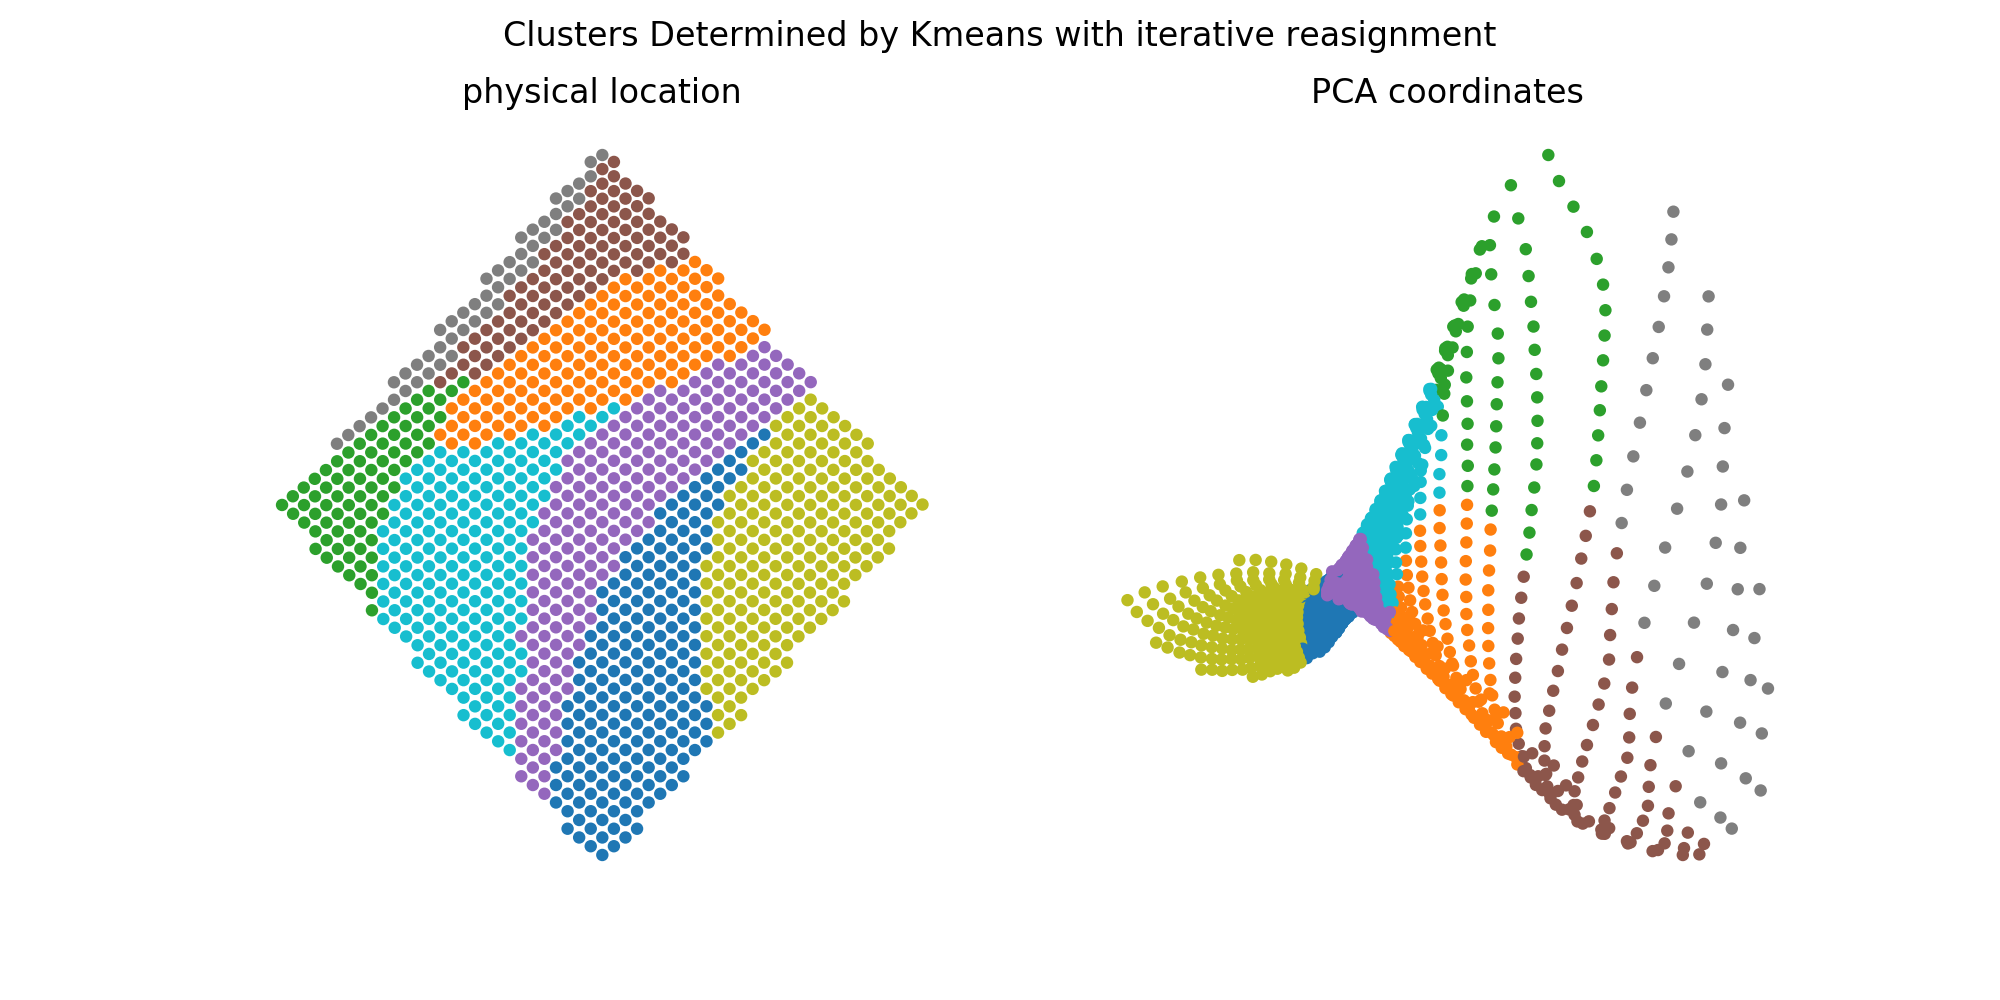

In [27]:
PV_double_scatter(cluster_ids, cmap='tab10', vmax=7,
           title='Clusters Determined by Kmeans with iterative reasignment'
          )

# DBScan Clustering

In [22]:
from sklearn.cluster import DBSCAN

Someone suggested exploring DBscan as a method to cluster based on irradiance profile. DBscan finds clusters of higher density sepearted by regions of lower density. The plot below shows irradiance for two times (9:30 and 15:30) on May 21. You can see two distinct clusters of values, the group with low y-values result from a shadow on the roof at 15:30. DBscan easily seperates these into two clusters, so you can see how DBscan could potentially be a good method for clustering based on shadow pattern.

However, when you look at the PCA diagram above there is a region of high density and a region of low density. The shadow moves across the roof slowly hour by hour, and taken in totality, there aren't multiple regions of high density. The result with DBscan on the 73-dimensional dataset is a single large cluster, with two small clusters along the top left edge.

Another problem with DBscan for this application is the inability to pre-determine the number of clusters. The system design has 8 electrical groups, so we want exactly that number of clusters.

<IPython.core.display.Javascript object>


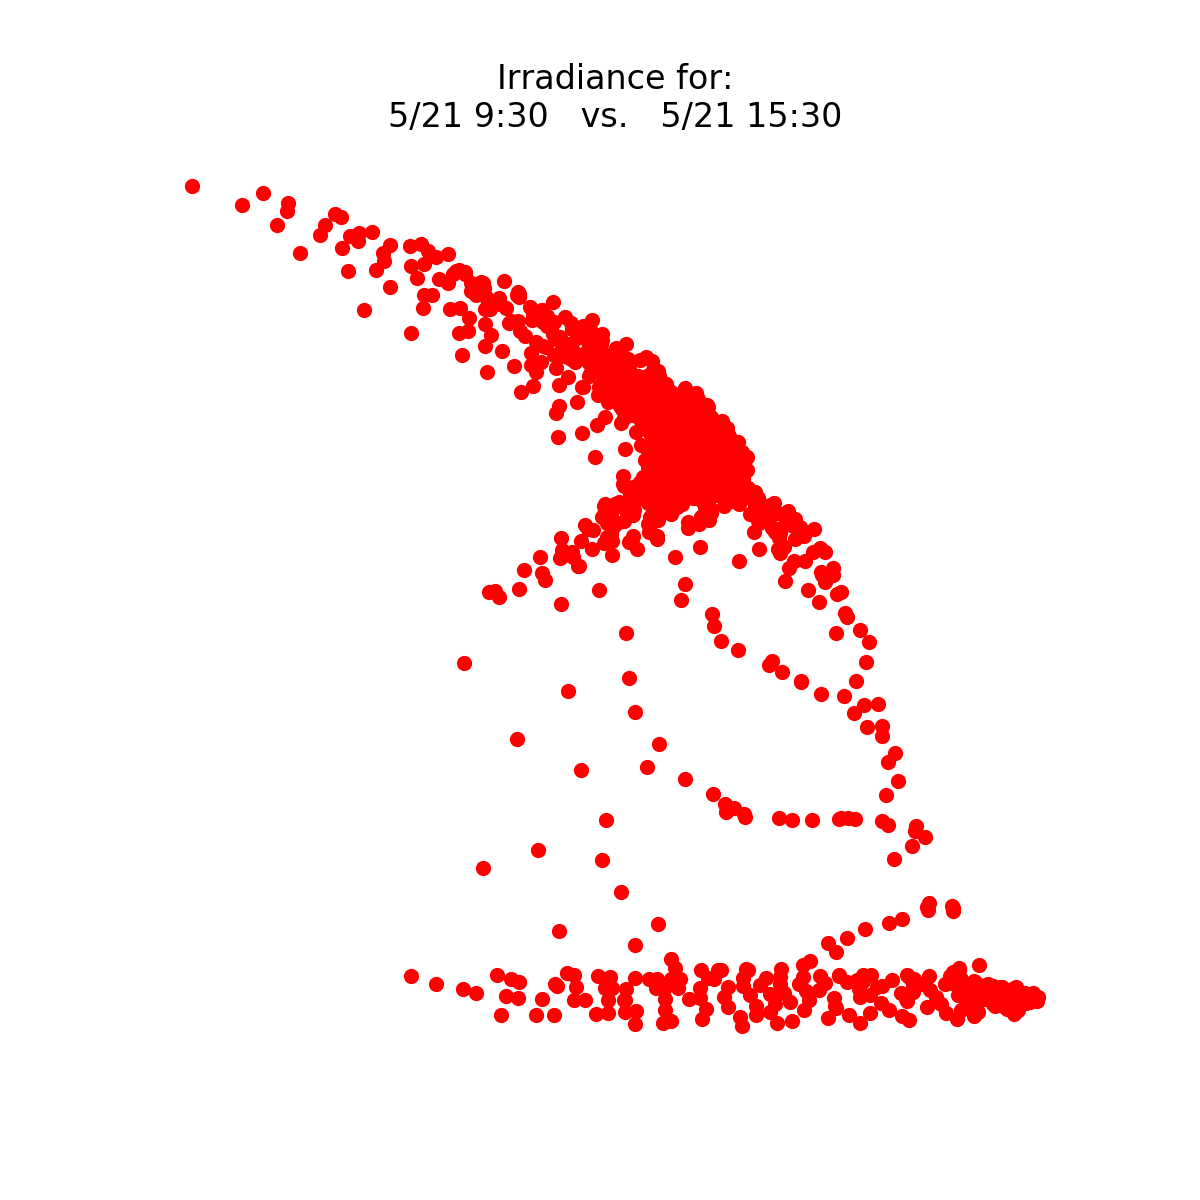

In [23]:
PV_scatter(PV_irrad_sunny_days.iloc[:,42], PV_irrad_sunny_days.iloc[:,48],
           color='red',
           size=20,
           vmax=irrad_max,
           title='Irradiance for:\n'+PV_irrad_sunny_days.columns[41]+'   vs.   '+PV_irrad_sunny_days.columns[47])

In [28]:
clust_db2d = DBSCAN(eps=20, min_samples=1)
clust_db2d.fit(np.array([PV_irrad_sunny_days.iloc[:,42], PV_irrad_sunny_days.iloc[:,48]]).T)

DBSCAN(algorithm='auto', eps=20, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=1, n_jobs=None, p=None)

<IPython.core.display.Javascript object>


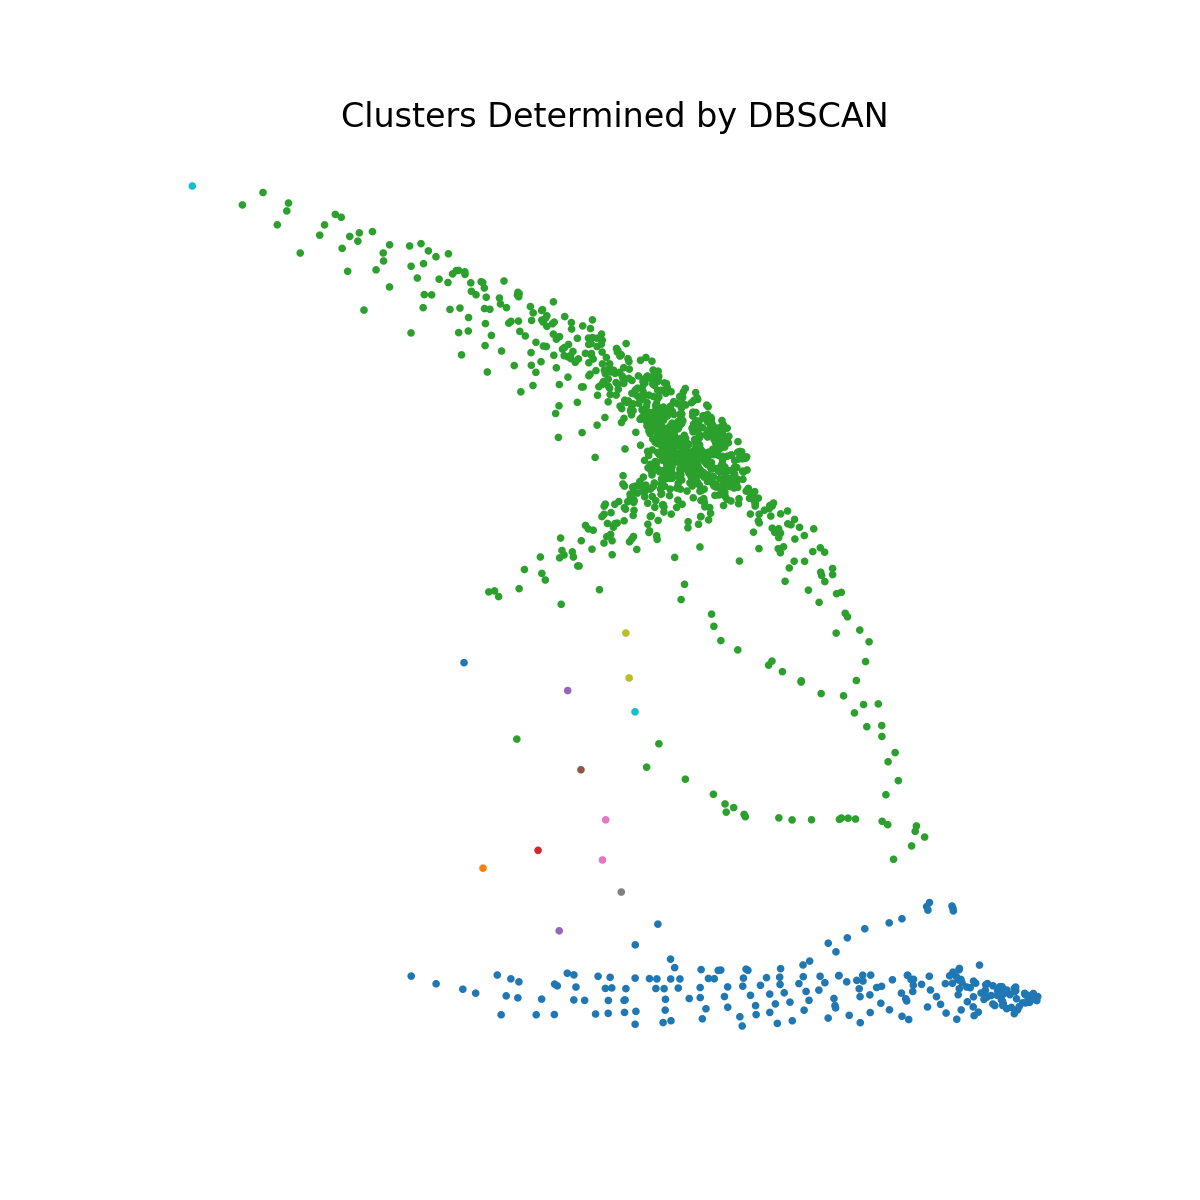

In [30]:
PV_scatter(PV_irrad_sunny_days.iloc[:,42], PV_irrad_sunny_days.iloc[:,48],
           color=clust_db2d.labels_, cmap='tab10', vmax=clust_db2d.labels_.max(),
           title='Clusters Determined by DBSCAN')

<IPython.core.display.Javascript object>


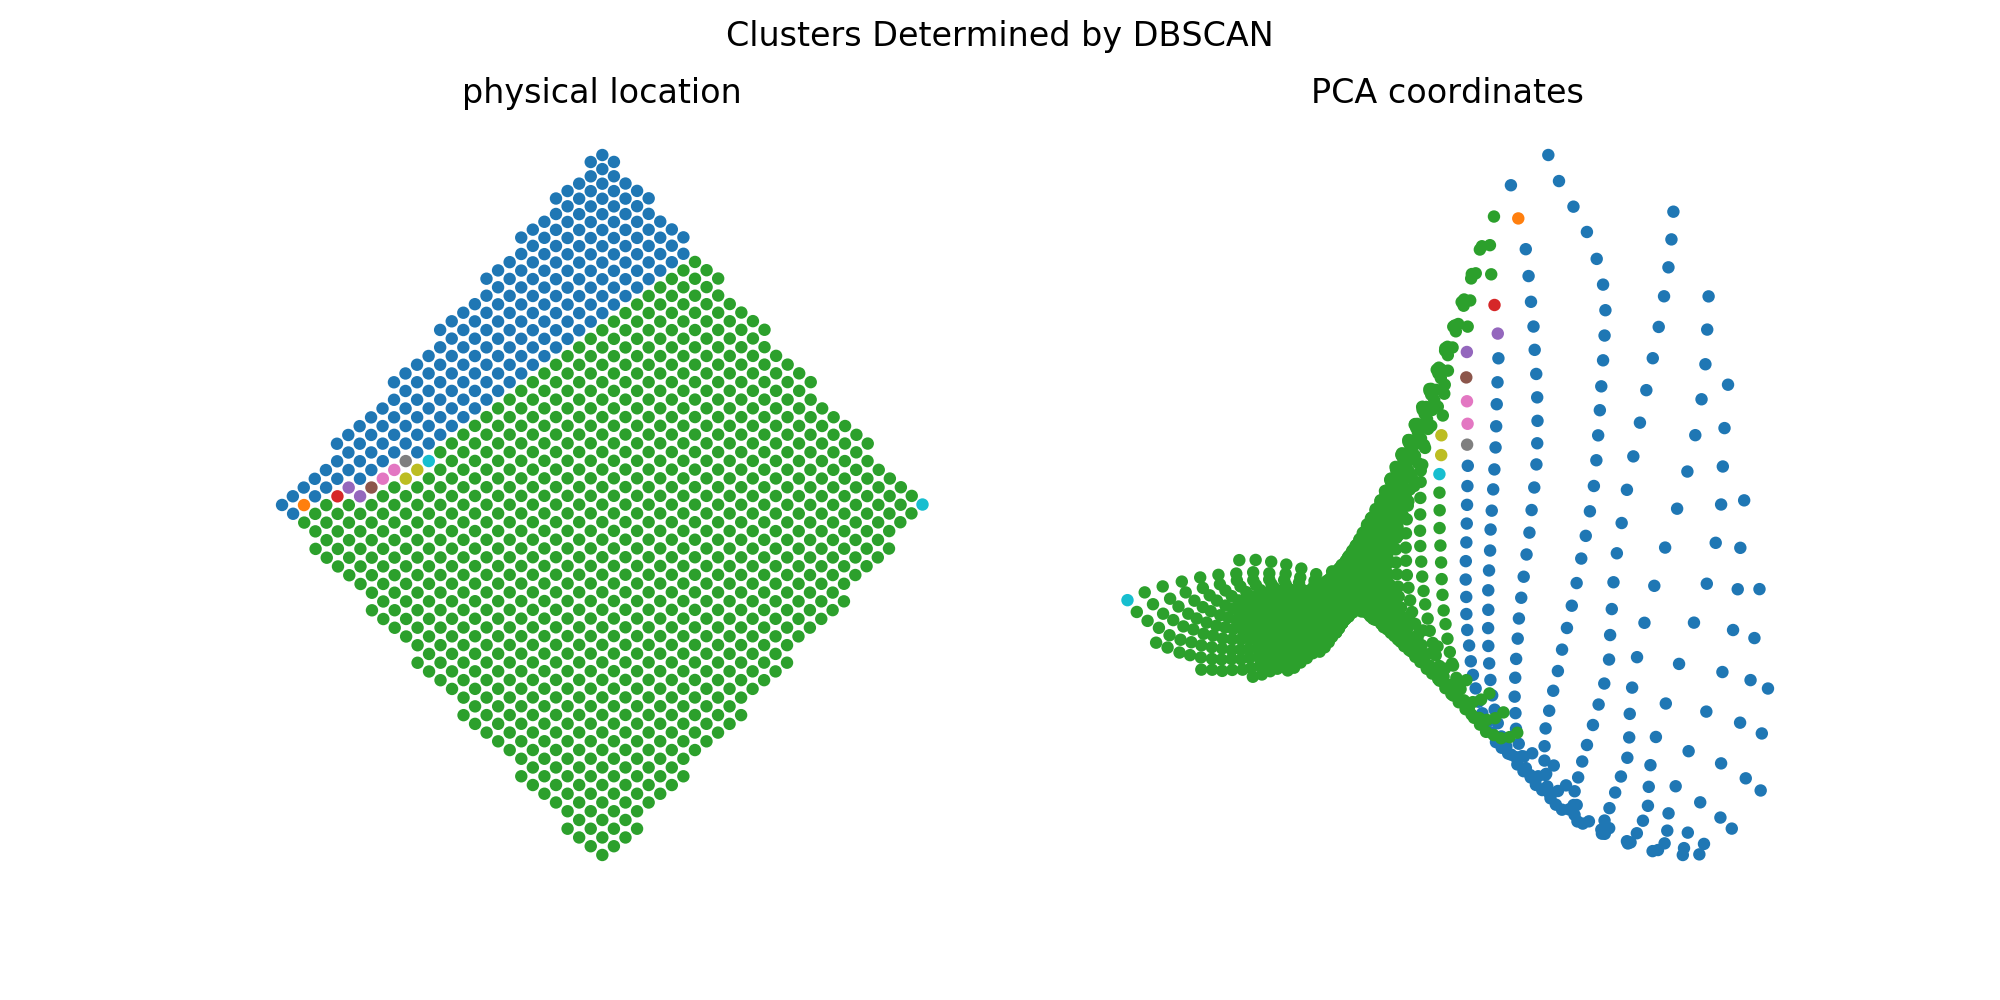

In [49]:
PV_double_scatter(clust_db2d.labels_, cmap='tab10', vmax=clust_db2d.labels_.max(), title='Clusters Determined by DBSCAN')

In [31]:
clust_db = DBSCAN(eps=300, leaf_size=30, min_samples=5)
clust_db.fit(PV_irrad_sunny_days)

DBSCAN(algorithm='auto', eps=300, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

<IPython.core.display.Javascript object>


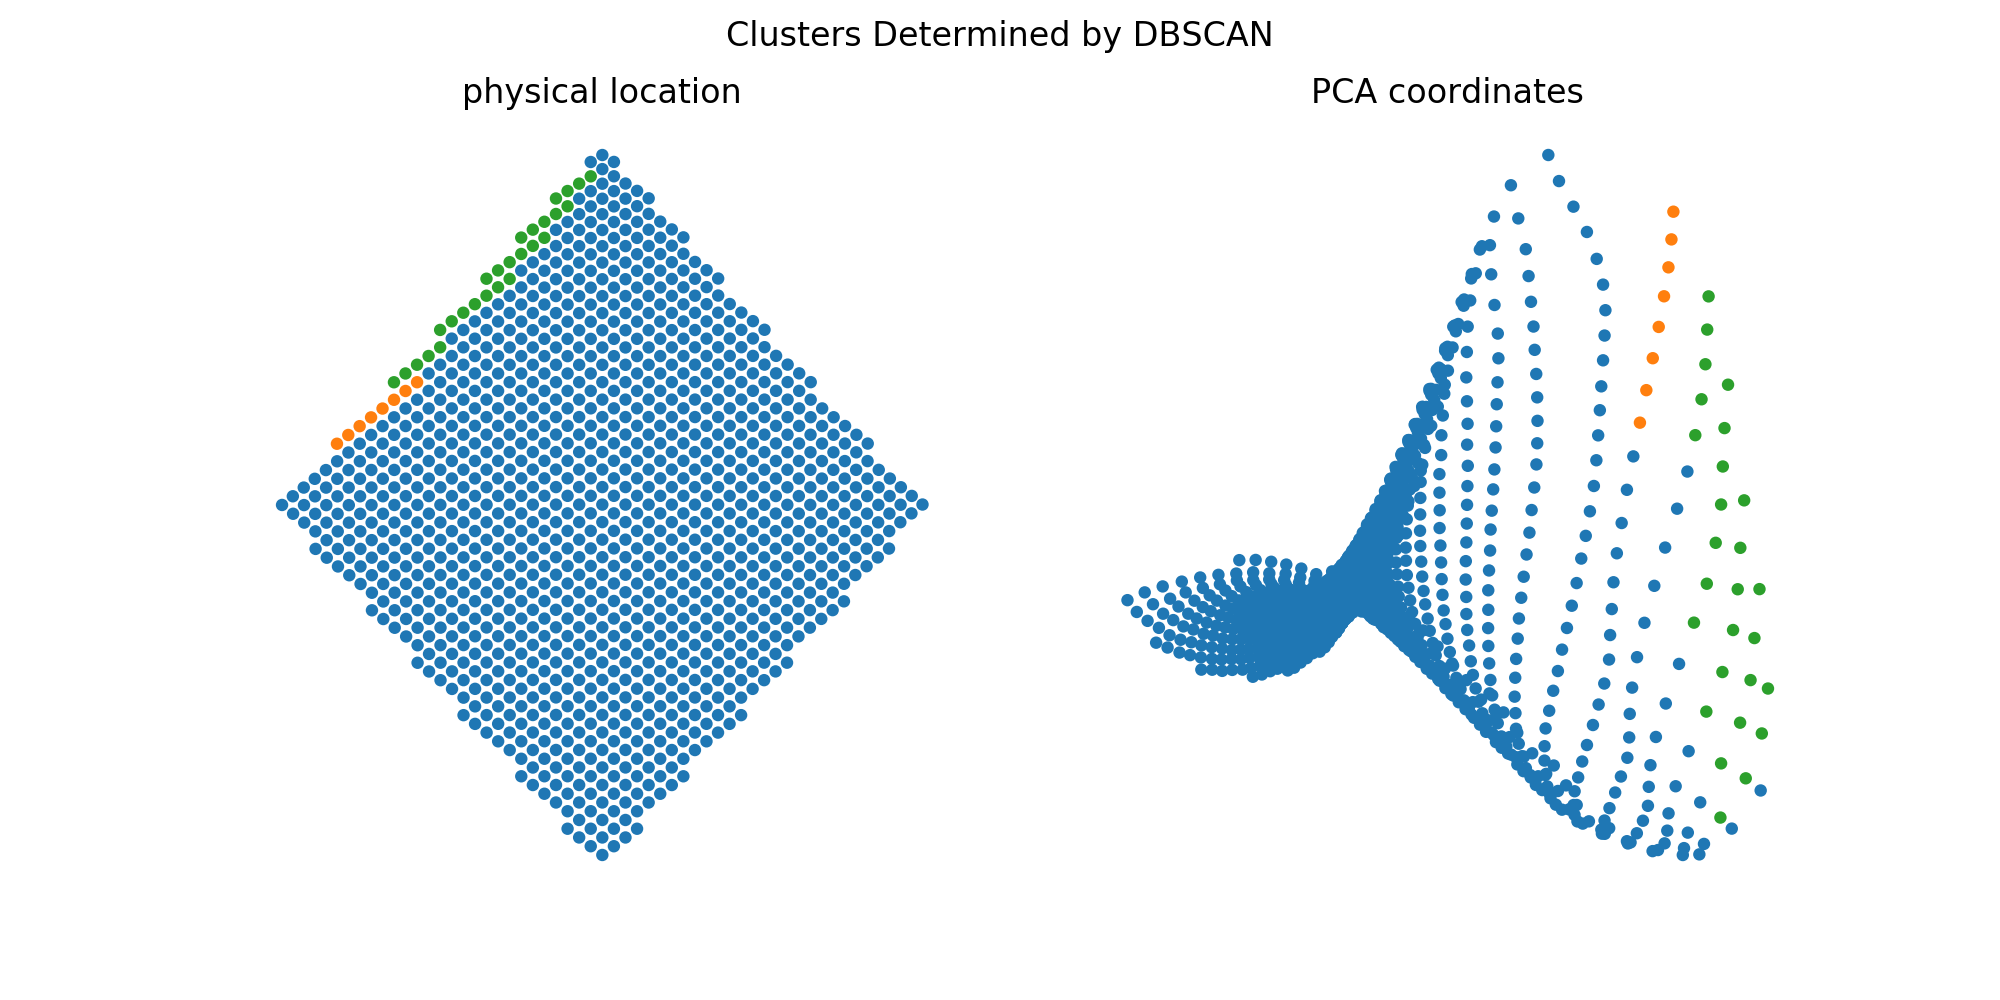

In [32]:
PV_double_scatter(clust_db.labels_, cmap='tab10', vmax=7, title='Clusters Determined by DBSCAN')

# Optimization
The other way to potenitally create groups is through optimization. The benefit of optimization is that you can include group size constraints as a penalty in the fitness function.

Below are two half-hearted attempts at generating groups with differential evolution optimizer. I could probably get a better result by improving the fitness function. I could probably improve the result by writing a discrete optimizer, or using a package with one. But based on these initial result, I don't think its worth the effort. These optimizations take hours to give a not good result.

## Optimization on cluster assignments
First trying a genetic algorithm using a continuous variable between 0-8. The group is asigned by casting to integers using floor to determine groupings. Very much a cludge but worth a try.

In [33]:
from scipy.optimize import differential_evolution

In [34]:
cluster_ids = np.random.randint(0,n_clust,(1175))
bounds = [ (0,7.9999) for i in range(len(cluster_ids))]

In [35]:
clustering_datapoints = PV_irrad_sunny_days.to_numpy()

In [36]:
def cost_function(cluster_floats):
    '''cost function for optimization, returns inertia multiplied by a penalty'''
    global clustering_datapoints, n_clust, cluster_minimum, cluster_maximum
    cluster_ids = np.array(np.floor(cluster_floats), dtype=np.int)
    cluster_centroids = calc_cluster_centers(clustering_datapoints, n_clust, cluster_ids)
    cluster_distances = calc_cluster_distances(clustering_datapoints, cluster_centroids)
    cluster_sizes = calc_cluster_sizes(cluster_ids, n_clust)
    inertia = calc_inertia(cluster_distances, cluster_ids)
    if not meets_size_constraints(cluster_sizes, cluster_minimum, cluster_maximum):
        inertia *= 2
    return inertia

In [37]:
%%time
ga_result = differential_evolution(cost_function, bounds, maxiter=1000, popsize=14, workers=7 )

/usr/local/lib/python3.7/site-packages/scipy/optimize/_differentialevolution.py:494: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  " updating='deferred'", UserWarning)


CPU times: user 3min 39s, sys: 25.9 s, total: 4min 5s
Wall time: 6min 17s


In [38]:
ga_result

     fun: 580627065.1676188
 message: 'Optimization terminated successfully.'
    nfev: 34076
     nit: 1
 success: True
       x: array([1.65226717, 3.02917196, 0.70802986, ..., 0.70396495, 1.48712337,
       4.73774523])

<IPython.core.display.Javascript object>


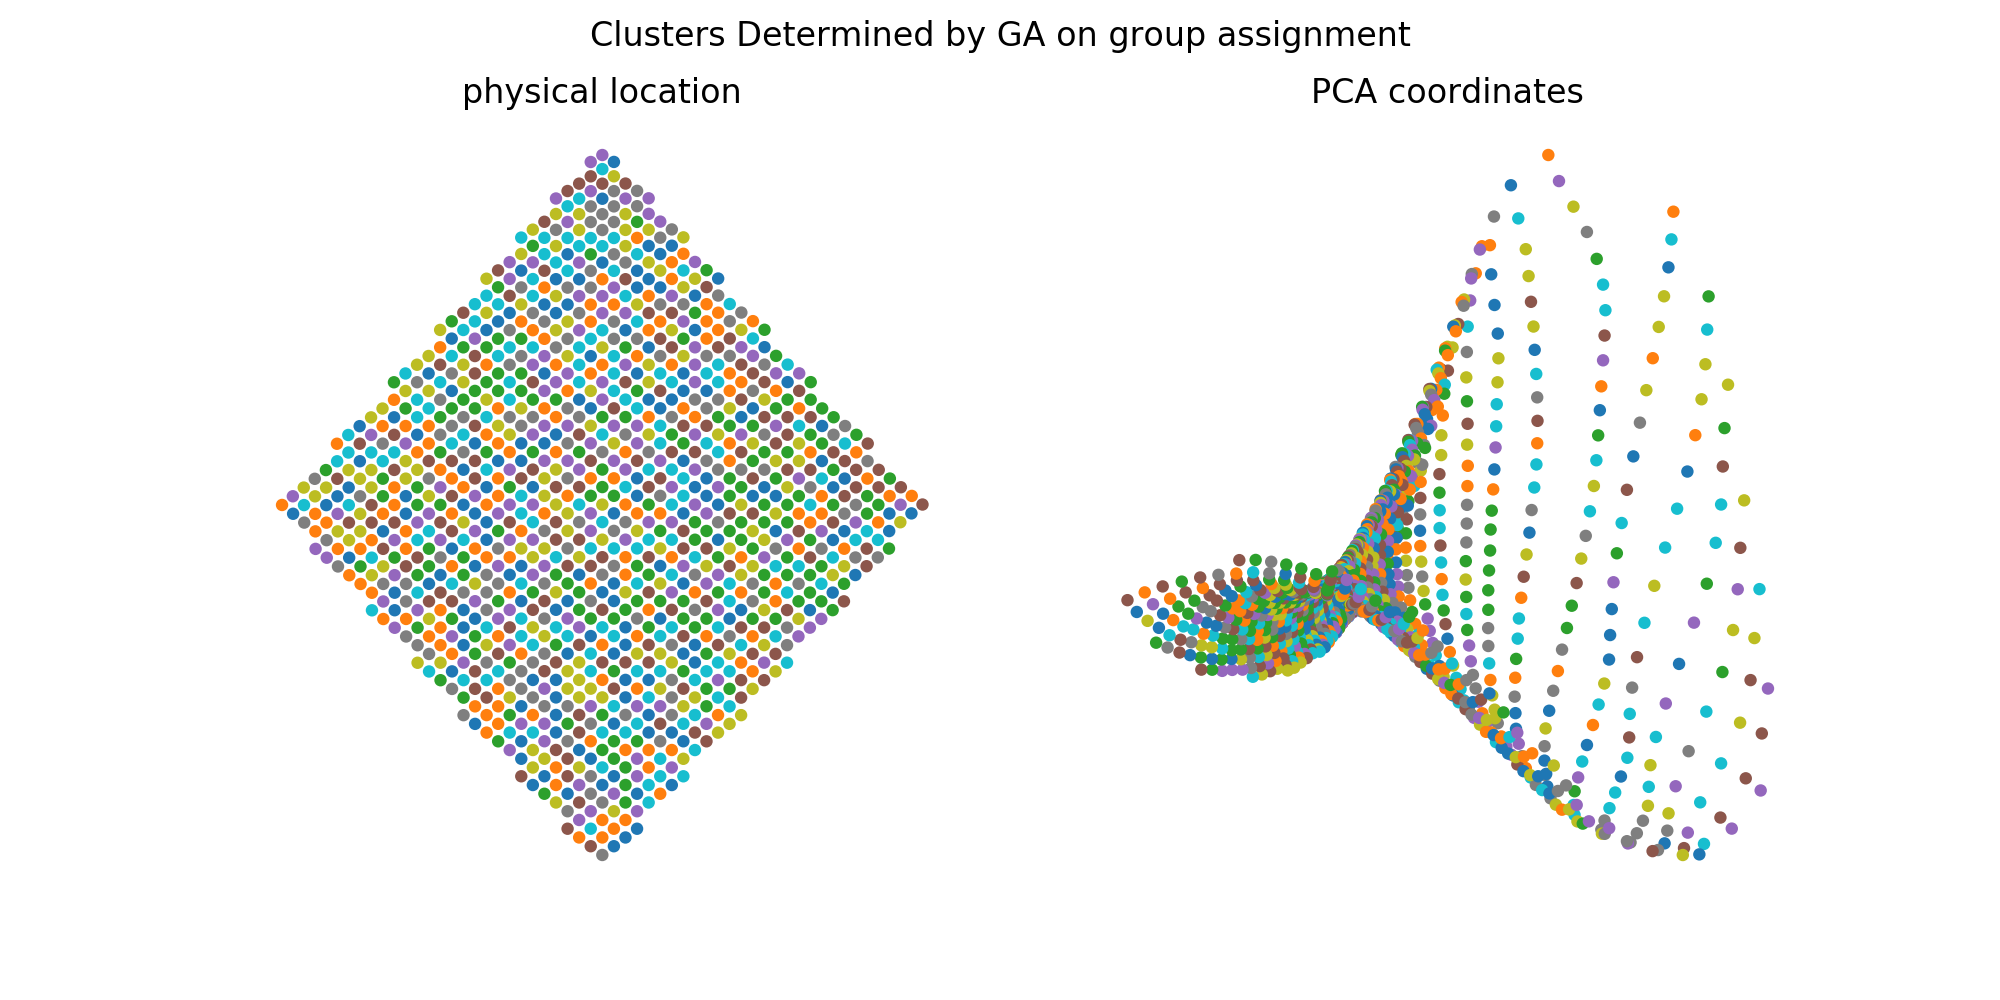

In [39]:
PV_double_scatter(np.floor(ga_result.x), cmap='tab10', vmax=7,
           title='Clusters Determined by GA on group assignment'
          )

Ha Ha! Yeah, no. The fitness function didn't improve much beyond the random assignment.

## Optimization on location of cluster centroids
This attempt instead tries to find cluster centroids with that minimize the cost function. there are 8*73 values to optimize.

In [40]:
cl_cent_shape = np.shape(clust_km.cluster_centers_)
ga_centroids = clust_km.cluster_centers_.ravel()

In [43]:
bounds2 = np.array([[ (min, max) for min, max in zip(PV_irrad_sunny_days.min(), PV_irrad_sunny_days.max()) ] 
                   for i in range(cl_cent_shape[0]) ]).reshape(len(ga_centroids),2)

In [44]:
def cost_function2(ga_centroids_flat):
    '''cost function for optimization, returns inertia multiplied by a penalty'''
    global clustering_datapoints, n_clust, cluster_minimum, cluster_maximum, cl_cent_shape
    ga_centroids = ga_centroids_flat.reshape(cl_cent_shape)
    ga_distances = calc_cluster_distances(clustering_datapoints, ga_centroids)
    ga_ids = assign_to_closest(ga_distances)
    ga_sizes = calc_cluster_sizes(ga_ids, n_clust)
    inertia = calc_inertia(ga_distances, ga_ids)
    if not meets_size_constraints(ga_sizes, cluster_minimum, cluster_maximum):
        inertia = inertia * 2
    return inertia

In [45]:
%%time
ga2_result = differential_evolution(cost_function2, bounds2, maxiter=100000, popsize=14, workers=7)

CPU times: user 1h 2min 38s, sys: 6min 8s, total: 1h 8min 47s
Wall time: 6h 14s


In [46]:
ga2_result

     fun: 579735657.819385
 message: 'Optimization terminated successfully.'
    nfev: 2559116
     nit: 310
 success: True
       x: array([ 411.3844197 ,  603.37649203,  593.95326208,  613.22383566,
        497.8370716 ,  290.50912182,  123.33831052,  515.55741815,
        720.48270597,  755.75503544,  744.02251019,  414.26986193,
         69.54773627,   65.51172232,   45.3269311 ,  234.8244983 ,
        505.65358583,  685.07120865,  862.19597622,  849.31272721,
        878.27864039,  714.79943199,  501.49962434,  200.80696655,
         84.38609673,  117.8144436 ,  239.0933588 ,  465.75738377,
        691.65381829,  821.86002318,  898.74114475,  961.6457097 ,
        898.20241094,  831.74547086,  518.83767953,  230.74284773,
        130.06683952,  125.53919988,  245.27633209,  475.52478948,
        707.45845673,  837.47830876,  975.5117338 ,  963.30345186,
        969.77724033,  815.5513627 ,  576.38036095,  332.30905509,
        117.37409557,   75.69961318,   89.5301162 ,  317.63288

1643462134.3456652 579735657.819385


<IPython.core.display.Javascript object>


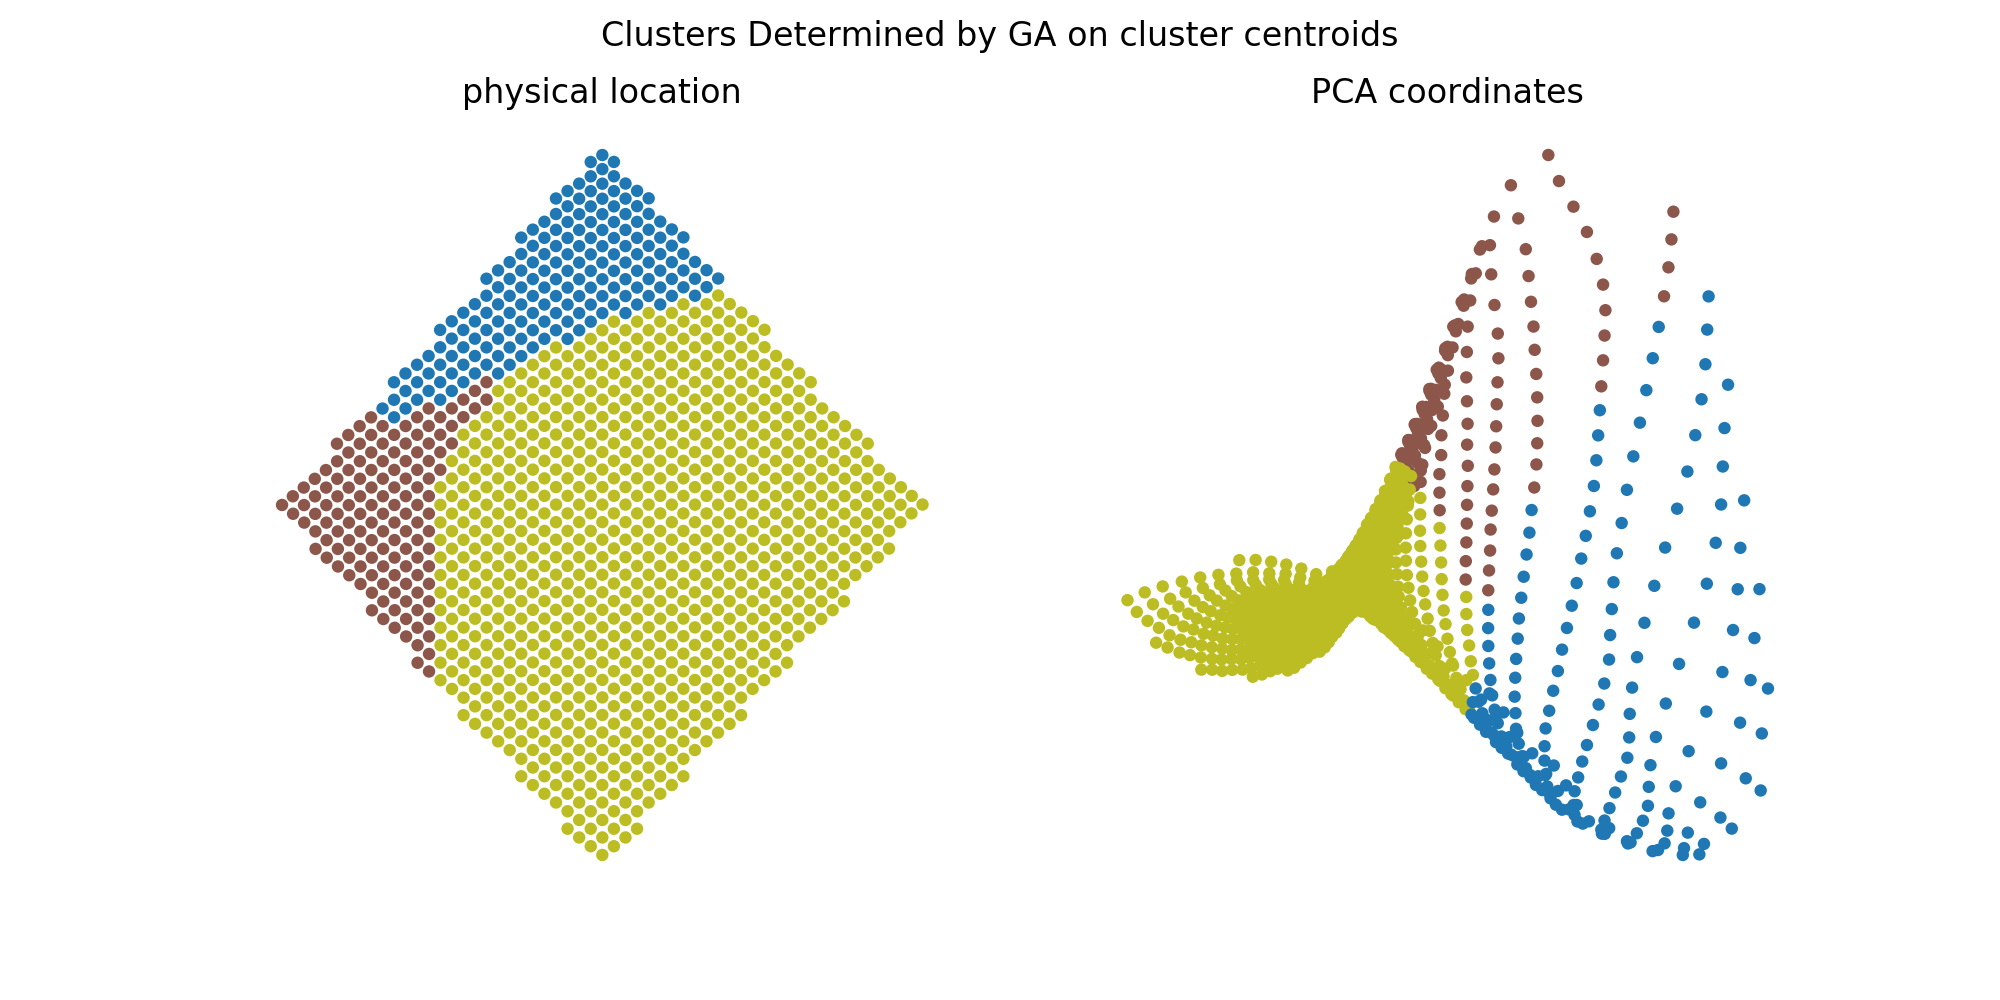

In [47]:
ga_distances = calc_cluster_distances(clustering_datapoints, ga2_result.x.reshape(cl_cent_shape))
ga_ids = assign_to_closest(ga_distances)
ga_sizes = calc_cluster_sizes(ga_ids, n_clust)
inertia = calc_inertia(ga_distances, cluster_ids)
cost = cost_function2(ga2_result.x)
print(inertia, cost)
PV_double_scatter(ga_ids, cmap='tab10', vmax=7,
           title='Clusters Determined by GA on cluster centroids'
          )